In [1]:
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_metric_learning import losses

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
from sklearn import metrics
import os
import torch.nn as nn

X=pd.read_excel('mimic/'+str(3)+'_mimictrainEncoded.xlsx').drop(columns=['Unnamed: 0'])
val=pd.read_excel('mimic/'+str(3)+'_mimicvalidationEncoded.xlsx').reindex(columns=X.columns)
vlabel=pd.read_csv('mimic/'+str(3)+'_mimicvalidationlabel.csv')['0']
y=pd.read_csv('mimic/'+str(3)+'_mimictrainlabel.csv')['0']
testlabel=pd.read_csv('mimic/'+str(3)+'_mimictestlabel.csv')['0']
test=pd.read_excel('mimic/'+str(3)+'_mimictestEncoded.xlsx').reindex(columns=X.columns)

In [3]:
X

,outputscore,isVarchar_1,isDate_1,isInt2_1,isInt4_1,isNumeric_1,isOther1,size_1,size_2,isVarchar_2,isDate_2,isInt2_2,isInt4_2,isNumeric_2,isOther2
0,0.001817,0,0,0,1,0,0,10,50,1,0,0,0,0,0
1,0.002074,0,0,0,1,0,0,10,50,1,0,0,0,0,0
2,0.002147,0,0,0,1,0,0,10,50,1,0,0,0,0,0
3,0.001968,0,0,0,1,0,0,10,50,1,0,0,0,0,0
4,0.001967,0,0,0,1,0,0,10,50,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39811,0.009423,1,0,0,0,0,0,50,22,0,1,0,0,0,0
39812,0.001834,1,0,0,0,0,0,50,22,0,1,0,0,0,0
39813,0.000753,0,0,0,1,0,0,10,22,0,1,0,0,0,0
39814,0.002025,1,0,0,0,0,0,50,22,0,1,0,0,0,0


In [8]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
from sklearn import metrics
import os
import torch.nn as nn

X=pd.read_csv('thalia/unseen_split/'+str(3)+'train_encode.csv').drop(columns=['Unnamed: 0'])
val=pd.read_csv('thalia/unseen_split/'+str(3)+'val_encode.csv').reindex(columns=X.columns)
vlabel=pd.read_csv('thalia/unseen_split/'+str(3)+'val_label.csv')['label']
y=pd.read_csv('thalia/unseen_split/'+str(3)+'train_label.csv')['label']
testlabel=pd.read_csv('thalia/unseen_split/'+str(3)+'test_label.csv')['label']
test=pd.read_csv('thalia/unseen_split/'+str(3)+'test_encode.csv').reindex(columns=X.columns)
class Dataset(Dataset):
    def __init__(self, x, y):
#         reader = pd.read_excel(fname)
        all_data = []
        for i in range(x.shape[0]):
            feature = torch.tensor(x.iloc[i].to_list(),dtype=torch.float32).to('cpu')
            class_n = torch.tensor(y[i],dtype=torch.long).to('cpu')
            data = {
                'features': feature,
                'class_n': int(class_n),
            }
            all_data.append(data)
        self.data = all_data
        print('finished data prepration')

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)
def _reset_params(model, initializer):
    for child in model.children():
        for p in child.parameters():
            if p.requires_grad:
                if initializer == 'uniform':
                    stdv = 1. / math.sqrt(p.shape[0])
                    torch.nn.init.uniform_(p, a=-stdv, b=stdv)
                elif initializer == 'normal':
                    torch.nn.init.normal_(p)
                elif initializer == 'dirac':
                    torch.nn.init.dirac_(p, groups=1)
                elif initializer == 'orthogonal':
                    torch.nn.init.orthogonal_(p,gain=1)
                elif initializer =='kaiming':
                    torch.nn.init.kaiming_uniform_(p,a=0,mode='fan_in',nonlinearity='leaky_relu')
                elif initializer == 'ones':
                    torch.nn.init.ones_(p)
                elif initializer=='xavier_normal':
                    torch.nn.init.xavier_normal_(p,gain=1.0)
train = X
val = val
test = test

"""Here you need input your real label, the lables shown here are just test the model"""
train_y = np.array(y)
val_y =  np.array(vlabel)
test_y = np.array(testlabel)


train = Dataset(train, train_y)
val = Dataset(val, val_y)
test = Dataset(test, test_y)

# Load training dataset labels
temp = [t['class_n'] for t in train]
# Count different classes sample number
class_sample_count = np.array([len(np.where(temp == t)[0]) for t in np.unique(temp)])
# Calculate weights for different classes
weight_temp = 1. / class_sample_count
# Apply weights to each sample
samples_weight = np.array([weight_temp[t] for t in temp])
samples_weight = torch.from_numpy(samples_weight)
# Build sampler for dataloader
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

train_x = DataLoader(dataset=train, batch_size=64, sampler = sampler)
val_x = DataLoader(dataset=val, batch_size=64, shuffle=False)
test_x = DataLoader(dataset=test, batch_size=64, shuffle=False)

def _evaluate_acc_f1(data_loader, model):
    n_correct, n_total = 0, 0
    t_targets_all, t_outputs_all = None, None
    # switch model to evaluation mode
    model.eval()
    with torch.no_grad():
        for t_batch, t_sample_batched in enumerate(data_loader):
            t_inputs = t_sample_batched['features']
            t_targets = t_sample_batched['class_n']
            t_outputs = model(t_inputs)
            n_correct += (torch.argmax(t_outputs, -1) == t_targets).sum().item()
            n_total += len(t_outputs)

            if t_targets_all is None:
                t_targets_all = t_targets
                t_outputs_all = t_outputs
            else:
                t_targets_all = torch.cat((t_targets_all, t_targets), dim=0)
                t_outputs_all = torch.cat((t_outputs_all, t_outputs), dim=0)
    
    acc = n_correct / n_total
    f1 = metrics.f1_score(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), labels=[0, 1], average='macro')
    report = classification_report(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), target_names=['class0','class1'], output_dict=True, digits = 4)
    return acc, f1, report



# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.

"""You should test different Hidden dimension, and learning rate to find the best model"""
N, D_in, H, D_out = 64, 11, 5, 2
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

_reset_params(model, 'uniform')
#===================================================================================#
epoch = 5000
class_weights = torch.FloatTensor([0.2, 0.8])
loss_fn = torch.nn.CrossEntropyLoss()
# learning_rate = 1e-4
learning_rate=9e-4
# learning_rate=2e-2
model.train()
global_step = 0
max_val_f1 = 0
n_correct, n_total, loss_total = 0, 0, 0
t_targets_all, t_outputs_all = None, None
best_threshold=0.5
#===================================================================================#

mimicloss=[]

for t in range(epoch):
    for i_batch, sample_batched in enumerate(train_x):        
        outputs = model(sample_batched['features'])
        targets = sample_batched['class_n']
#         m=torch.nn.Softmax(dim=1)
#         output_new = m(outputs)
#         threshold=sorted(output_new.detach().numpy(),reverse=True,key=lambda x:x[1])[sum(targets)][1]
# #         print("threshold is ",threshold)
#         output_modified = output_new.clone()
#         output_modified[output_new[:, 1] >= threshold, 1] = 1
#         output_modified[output_new[:, 1] < threshold, 1] = -1e9
#         print(output_modified)
        loss = loss_fn(outputs, targets)     
        model.zero_grad()
        loss.backward()
        
        if t_targets_all is None:
            t_targets_all = targets
            t_outputs_all = outputs
        else:
            t_targets_all = torch.cat((t_targets_all, targets), dim=0)
            t_outputs_all = torch.cat((t_outputs_all, outputs), dim=0)
            
#         report = classification_report(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), target_names=['class0','class1'], output_dict=True, digits = 4)
        
        n_correct += (torch.argmax(outputs, -1) == targets).sum().item()
        n_total += len(outputs)
        loss_total += loss.item() * len(outputs)
        if global_step % 2 == 0:
            train_acc = n_correct / n_total
            train_loss = loss_total / n_total
            mimicloss.append(train_loss)
            print('loss: {:.4f}, acc: {:.4f}'.format(train_loss, train_acc))
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad
    #=============================================================
    #validation
    #val_acc, val_f1, report_val,th = _evaluate_acc_f1_threshold(val_x, model,best_threshold)#validation set with threshold
    val_acc, val_f1, report_val = _evaluate_acc_f1(val_x, model)
    print('val_report: {}'.format(report_val['class1']))
    if report_val['class1']['f1-score'] > max_val_f1:
                max_val_f1 = report_val['class1']['f1-score']
                if not os.path.exists('state_dict/'+'thalia'):
                    os.mkdir('state_dict/'+'thalia')
                path = 'state_dict/'+'thalia'+'/{0}_{1}_val_f1_{2}'.format('neuralNet', 'thalia', round(report_val['class1']['f1-score'], 4))
                torch.save(model.state_dict(), path)        

#predict on test
best_path = path

model.load_state_dict(torch.load(best_path,map_location=torch.device('cpu')))
model.eval()
#test_acc, test_f1, report_test  = _evaluate_acc_f1_threshold(test_x, model,best_threshold)#evaluation with threshold
test_acc, test_f1, report_test  = _evaluate_acc_f1(test_x, model)
report_test

finished data prepration
finished data prepration
finished data prepration
loss: 10.4701, acc: 0.5469
loss: 10.0350, acc: 0.5391
loss: 15.2515, acc: 0.4635
loss: 12.8402, acc: 0.4570
loss: 11.4632, acc: 0.4781
loss: 10.3607, acc: 0.4740
loss: 9.6032, acc: 0.4732
loss: 8.6824, acc: 0.4824
loss: 8.0149, acc: 0.4826
loss: 7.4775, acc: 0.4859
loss: 7.1534, acc: 0.4901
loss: 6.8002, acc: 0.4914
val_report: {'precision': 0.043478260869565216, 'recall': 1.0, 'f1-score': 0.08333333333333333, 'support': 5}
loss: 6.3727, acc: 0.5006
loss: 6.0009, acc: 0.5130
loss: 5.6791, acc: 0.5153
loss: 5.4761, acc: 0.5203
loss: 5.2809, acc: 0.5209
loss: 5.0334, acc: 0.5250
loss: 4.8258, acc: 0.5287
loss: 4.6302, acc: 0.5367
loss: 4.4567, acc: 0.5417
loss: 4.2982, acc: 0.5419
loss: 4.1747, acc: 0.5449
loss: 4.0673, acc: 0.5450
val_report: {'precision': 0.04938271604938271, 'recall': 0.8, 'f1-score': 0.09302325581395349, 'support': 5}
loss: 3.9326, acc: 0.5470
loss: 3.8126, acc: 0.5482
loss: 3.7071, acc: 0.548

loss: 0.9266, acc: 0.5386
loss: 0.9258, acc: 0.5389
loss: 0.9254, acc: 0.5387
loss: 0.9252, acc: 0.5385
loss: 0.9248, acc: 0.5386
val_report: {'precision': 0.047619047619047616, 'recall': 1.0, 'f1-score': 0.0909090909090909, 'support': 5}
loss: 0.9240, acc: 0.5388
loss: 0.9233, acc: 0.5390
loss: 0.9227, acc: 0.5388
loss: 0.9223, acc: 0.5387
loss: 0.9215, acc: 0.5389
loss: 0.9207, acc: 0.5392
loss: 0.9201, acc: 0.5392
loss: 0.9195, acc: 0.5390
loss: 0.9188, acc: 0.5390
loss: 0.9182, acc: 0.5388
loss: 0.9175, acc: 0.5390
loss: 0.9170, acc: 0.5389
val_report: {'precision': 0.049019607843137254, 'recall': 1.0, 'f1-score': 0.09345794392523364, 'support': 5}
loss: 0.9163, acc: 0.5390
loss: 0.9156, acc: 0.5392
loss: 0.9151, acc: 0.5390
loss: 0.9145, acc: 0.5390
loss: 0.9139, acc: 0.5389
loss: 0.9133, acc: 0.5387
loss: 0.9127, acc: 0.5388
loss: 0.9121, acc: 0.5387
loss: 0.9115, acc: 0.5389
loss: 0.9110, acc: 0.5387
loss: 0.9105, acc: 0.5385
loss: 0.9101, acc: 0.5384
val_report: {'precision': 0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

loss: 0.8366, acc: 0.5427
loss: 0.8363, acc: 0.5427
loss: 0.8359, acc: 0.5429
loss: 0.8356, acc: 0.5431
loss: 0.8352, acc: 0.5432
loss: 0.8349, acc: 0.5433
loss: 0.8348, acc: 0.5432
loss: 0.8349, acc: 0.5431
val_report: {'precision': 0.04310344827586207, 'recall': 1.0, 'f1-score': 0.08264462809917356, 'support': 5}
loss: 0.8350, acc: 0.5429
loss: 0.8349, acc: 0.5428
loss: 0.8346, acc: 0.5429
loss: 0.8344, acc: 0.5429
loss: 0.8343, acc: 0.5430
loss: 0.8341, acc: 0.5430
loss: 0.8338, acc: 0.5432
loss: 0.8336, acc: 0.5433
loss: 0.8333, acc: 0.5433
loss: 0.8331, acc: 0.5433
loss: 0.8328, acc: 0.5435
loss: 0.8325, acc: 0.5436
val_report: {'precision': 0.060240963855421686, 'recall': 1.0, 'f1-score': 0.11363636363636363, 'support': 5}
loss: 0.8323, acc: 0.5434
loss: 0.8321, acc: 0.5433
loss: 0.8321, acc: 0.5431
loss: 0.8318, acc: 0.5433
loss: 0.8315, acc: 0.5435
loss: 0.8312, acc: 0.5436
loss: 0.8308, acc: 0.5438
loss: 0.8306, acc: 0.5438
loss: 0.8303, acc: 0.5437
loss: 0.8301, acc: 0.5437
l

val_report: {'precision': 0.0684931506849315, 'recall': 1.0, 'f1-score': 0.1282051282051282, 'support': 5}
loss: 0.7736, acc: 0.5568
loss: 0.7734, acc: 0.5568
loss: 0.7733, acc: 0.5568
loss: 0.7732, acc: 0.5569
loss: 0.7731, acc: 0.5569
loss: 0.7730, acc: 0.5569
loss: 0.7728, acc: 0.5569
loss: 0.7728, acc: 0.5569
loss: 0.7726, acc: 0.5569
loss: 0.7726, acc: 0.5570
loss: 0.7724, acc: 0.5571
loss: 0.7724, acc: 0.5571
val_report: {'precision': 0.08196721311475409, 'recall': 1.0, 'f1-score': 0.1515151515151515, 'support': 5}
loss: 0.7722, acc: 0.5573
loss: 0.7721, acc: 0.5573
loss: 0.7719, acc: 0.5575
loss: 0.7717, acc: 0.5575
loss: 0.7716, acc: 0.5574
loss: 0.7714, acc: 0.5575
loss: 0.7713, acc: 0.5574
loss: 0.7712, acc: 0.5574
loss: 0.7711, acc: 0.5576
loss: 0.7710, acc: 0.5576
loss: 0.7711, acc: 0.5577
loss: 0.7710, acc: 0.5577
val_report: {'precision': 0.060240963855421686, 'recall': 1.0, 'f1-score': 0.11363636363636363, 'support': 5}
loss: 0.7709, acc: 0.5577
loss: 0.7707, acc: 0.5578

loss: 0.7437, acc: 0.5703
loss: 0.7436, acc: 0.5703
loss: 0.7435, acc: 0.5703
loss: 0.7434, acc: 0.5703
loss: 0.7434, acc: 0.5703
loss: 0.7434, acc: 0.5703
loss: 0.7433, acc: 0.5704
val_report: {'precision': 0.14285714285714285, 'recall': 0.8, 'f1-score': 0.24242424242424243, 'support': 5}
loss: 0.7433, acc: 0.5704
loss: 0.7433, acc: 0.5705
loss: 0.7432, acc: 0.5706
loss: 0.7431, acc: 0.5707
loss: 0.7430, acc: 0.5707
loss: 0.7430, acc: 0.5708
loss: 0.7429, acc: 0.5708
loss: 0.7428, acc: 0.5709
loss: 0.7429, acc: 0.5709
loss: 0.7428, acc: 0.5710
loss: 0.7428, acc: 0.5710
loss: 0.7427, acc: 0.5710
val_report: {'precision': 0.09259259259259259, 'recall': 1.0, 'f1-score': 0.1694915254237288, 'support': 5}
loss: 0.7427, acc: 0.5711
loss: 0.7427, acc: 0.5711
loss: 0.7426, acc: 0.5711
loss: 0.7426, acc: 0.5711
loss: 0.7425, acc: 0.5713
loss: 0.7424, acc: 0.5713
loss: 0.7423, acc: 0.5714
loss: 0.7423, acc: 0.5714
loss: 0.7423, acc: 0.5714
loss: 0.7422, acc: 0.5714
loss: 0.7421, acc: 0.5715
los

loss: 0.7256, acc: 0.5853
loss: 0.7255, acc: 0.5854
loss: 0.7254, acc: 0.5854
loss: 0.7254, acc: 0.5855
loss: 0.7253, acc: 0.5855
loss: 0.7252, acc: 0.5856
loss: 0.7252, acc: 0.5856
loss: 0.7251, acc: 0.5856
loss: 0.7250, acc: 0.5857
loss: 0.7250, acc: 0.5857
loss: 0.7249, acc: 0.5858
val_report: {'precision': 0.0847457627118644, 'recall': 1.0, 'f1-score': 0.15625, 'support': 5}
loss: 0.7249, acc: 0.5859
loss: 0.7248, acc: 0.5859
loss: 0.7248, acc: 0.5859
loss: 0.7248, acc: 0.5859
loss: 0.7247, acc: 0.5859
loss: 0.7247, acc: 0.5860
loss: 0.7247, acc: 0.5860
loss: 0.7246, acc: 0.5861
loss: 0.7245, acc: 0.5862
loss: 0.7246, acc: 0.5863
loss: 0.7245, acc: 0.5863
loss: 0.7245, acc: 0.5863
val_report: {'precision': 0.1724137931034483, 'recall': 1.0, 'f1-score': 0.29411764705882354, 'support': 5}
loss: 0.7245, acc: 0.5864
loss: 0.7244, acc: 0.5865
loss: 0.7244, acc: 0.5866
loss: 0.7243, acc: 0.5866
loss: 0.7242, acc: 0.5866
loss: 0.7241, acc: 0.5866
loss: 0.7241, acc: 0.5867
loss: 0.7241, ac

loss: 0.7141, acc: 0.5969
loss: 0.7140, acc: 0.5970
loss: 0.7140, acc: 0.5971
loss: 0.7139, acc: 0.5971
loss: 0.7139, acc: 0.5971
val_report: {'precision': 0.11627906976744186, 'recall': 1.0, 'f1-score': 0.20833333333333334, 'support': 5}
loss: 0.7139, acc: 0.5971
loss: 0.7138, acc: 0.5971
loss: 0.7138, acc: 0.5971
loss: 0.7137, acc: 0.5971
loss: 0.7137, acc: 0.5972
loss: 0.7136, acc: 0.5972
loss: 0.7136, acc: 0.5973
loss: 0.7135, acc: 0.5974
loss: 0.7135, acc: 0.5974
loss: 0.7134, acc: 0.5975
loss: 0.7135, acc: 0.5975
loss: 0.7135, acc: 0.5976
val_report: {'precision': 0.10416666666666667, 'recall': 1.0, 'f1-score': 0.18867924528301885, 'support': 5}
loss: 0.7135, acc: 0.5975
loss: 0.7134, acc: 0.5975
loss: 0.7134, acc: 0.5976
loss: 0.7133, acc: 0.5976
loss: 0.7133, acc: 0.5976
loss: 0.7132, acc: 0.5977
loss: 0.7132, acc: 0.5977
loss: 0.7131, acc: 0.5978
loss: 0.7131, acc: 0.5978
loss: 0.7131, acc: 0.5979
loss: 0.7130, acc: 0.5979
loss: 0.7130, acc: 0.5979
val_report: {'precision': 0.

val_report: {'precision': 0.13157894736842105, 'recall': 1.0, 'f1-score': 0.23255813953488372, 'support': 5}
loss: 0.7038, acc: 0.6106
loss: 0.7038, acc: 0.6106
loss: 0.7038, acc: 0.6107
loss: 0.7037, acc: 0.6107
loss: 0.7037, acc: 0.6107
loss: 0.7036, acc: 0.6108
loss: 0.7036, acc: 0.6108
loss: 0.7035, acc: 0.6109
loss: 0.7035, acc: 0.6109
loss: 0.7035, acc: 0.6110
loss: 0.7034, acc: 0.6110
loss: 0.7034, acc: 0.6110
val_report: {'precision': 0.10638297872340426, 'recall': 1.0, 'f1-score': 0.1923076923076923, 'support': 5}
loss: 0.7034, acc: 0.6110
loss: 0.7034, acc: 0.6110
loss: 0.7033, acc: 0.6111
loss: 0.7032, acc: 0.6111
loss: 0.7032, acc: 0.6112
loss: 0.7032, acc: 0.6112
loss: 0.7031, acc: 0.6112
loss: 0.7031, acc: 0.6113
loss: 0.7031, acc: 0.6113
loss: 0.7031, acc: 0.6114
loss: 0.7031, acc: 0.6114
loss: 0.7031, acc: 0.6114
val_report: {'precision': 0.09803921568627451, 'recall': 1.0, 'f1-score': 0.17857142857142855, 'support': 5}
loss: 0.7031, acc: 0.6114
loss: 0.7030, acc: 0.611

loss: 0.6964, acc: 0.6200
loss: 0.6963, acc: 0.6200
loss: 0.6963, acc: 0.6200
loss: 0.6963, acc: 0.6201
loss: 0.6962, acc: 0.6201
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.6962, acc: 0.6201
loss: 0.6962, acc: 0.6202
loss: 0.6961, acc: 0.6202
loss: 0.6961, acc: 0.6203
loss: 0.6961, acc: 0.6203
loss: 0.6961, acc: 0.6204
loss: 0.6960, acc: 0.6204
loss: 0.6960, acc: 0.6205
loss: 0.6960, acc: 0.6205
loss: 0.6959, acc: 0.6206
loss: 0.6959, acc: 0.6206
loss: 0.6959, acc: 0.6206
val_report: {'precision': 0.1282051282051282, 'recall': 1.0, 'f1-score': 0.22727272727272727, 'support': 5}
loss: 0.6959, acc: 0.6206
loss: 0.6958, acc: 0.6207
loss: 0.6958, acc: 0.6207
loss: 0.6958, acc: 0.6208
loss: 0.6957, acc: 0.6209
loss: 0.6957, acc: 0.6209
loss: 0.6957, acc: 0.6210
loss: 0.6957, acc: 0.6210
loss: 0.6957, acc: 0.6210
loss: 0.6956, acc: 0.6211
loss: 0.6956, acc: 0.6211
loss: 0.6955, acc: 0.6212
val_report: {'precision': 0.151

loss: 0.6916, acc: 0.6274
loss: 0.6916, acc: 0.6274
loss: 0.6916, acc: 0.6274
loss: 0.6915, acc: 0.6275
loss: 0.6915, acc: 0.6276
loss: 0.6915, acc: 0.6276
val_report: {'precision': 0.13513513513513514, 'recall': 1.0, 'f1-score': 0.2380952380952381, 'support': 5}
loss: 0.6914, acc: 0.6276
loss: 0.6914, acc: 0.6276
loss: 0.6915, acc: 0.6276
loss: 0.6915, acc: 0.6277
loss: 0.6914, acc: 0.6277
loss: 0.6914, acc: 0.6278
loss: 0.6914, acc: 0.6278
loss: 0.6913, acc: 0.6278
loss: 0.6913, acc: 0.6279
loss: 0.6912, acc: 0.6279
loss: 0.6912, acc: 0.6280
loss: 0.6912, acc: 0.6280
val_report: {'precision': 0.1388888888888889, 'recall': 1.0, 'f1-score': 0.24390243902439027, 'support': 5}
loss: 0.6912, acc: 0.6280
loss: 0.6912, acc: 0.6280
loss: 0.6912, acc: 0.6281
loss: 0.6912, acc: 0.6281
loss: 0.6912, acc: 0.6281
loss: 0.6911, acc: 0.6281
loss: 0.6911, acc: 0.6282
loss: 0.6910, acc: 0.6283
loss: 0.6910, acc: 0.6283
loss: 0.6910, acc: 0.6283
loss: 0.6910, acc: 0.6283
loss: 0.6909, acc: 0.6283
val_

loss: 0.6857, acc: 0.6342
loss: 0.6857, acc: 0.6343
val_report: {'precision': 0.2, 'recall': 1.0, 'f1-score': 0.33333333333333337, 'support': 5}
loss: 0.6857, acc: 0.6343
loss: 0.6857, acc: 0.6342
loss: 0.6857, acc: 0.6342
loss: 0.6857, acc: 0.6342
loss: 0.6857, acc: 0.6342
loss: 0.6857, acc: 0.6342
loss: 0.6857, acc: 0.6342
loss: 0.6856, acc: 0.6342
loss: 0.6856, acc: 0.6343
loss: 0.6856, acc: 0.6343
loss: 0.6855, acc: 0.6343
loss: 0.6855, acc: 0.6343
val_report: {'precision': 0.15151515151515152, 'recall': 1.0, 'f1-score': 0.2631578947368421, 'support': 5}
loss: 0.6855, acc: 0.6343
loss: 0.6856, acc: 0.6343
loss: 0.6855, acc: 0.6344
loss: 0.6855, acc: 0.6344
loss: 0.6855, acc: 0.6344
loss: 0.6855, acc: 0.6345
loss: 0.6855, acc: 0.6345
loss: 0.6854, acc: 0.6346
loss: 0.6854, acc: 0.6346
loss: 0.6854, acc: 0.6346
loss: 0.6854, acc: 0.6346
loss: 0.6853, acc: 0.6346
val_report: {'precision': 0.15151515151515152, 'recall': 1.0, 'f1-score': 0.2631578947368421, 'support': 5}
loss: 0.6853, a

val_report: {'precision': 0.15151515151515152, 'recall': 1.0, 'f1-score': 0.2631578947368421, 'support': 5}
loss: 0.6800, acc: 0.6415
loss: 0.6799, acc: 0.6415
loss: 0.6799, acc: 0.6415
loss: 0.6799, acc: 0.6415
loss: 0.6799, acc: 0.6416
loss: 0.6799, acc: 0.6416
loss: 0.6799, acc: 0.6417
loss: 0.6800, acc: 0.6417
loss: 0.6800, acc: 0.6417
loss: 0.6800, acc: 0.6417
loss: 0.6800, acc: 0.6417
loss: 0.6800, acc: 0.6417
val_report: {'precision': 0.15151515151515152, 'recall': 1.0, 'f1-score': 0.2631578947368421, 'support': 5}
loss: 0.6800, acc: 0.6417
loss: 0.6799, acc: 0.6418
loss: 0.6799, acc: 0.6418
loss: 0.6800, acc: 0.6418
loss: 0.6799, acc: 0.6419
loss: 0.6799, acc: 0.6419
loss: 0.6799, acc: 0.6419
loss: 0.6799, acc: 0.6419
loss: 0.6799, acc: 0.6420
loss: 0.6798, acc: 0.6420
loss: 0.6798, acc: 0.6420
loss: 0.6798, acc: 0.6420
val_report: {'precision': 0.16129032258064516, 'recall': 1.0, 'f1-score': 0.27777777777777773, 'support': 5}
loss: 0.6798, acc: 0.6420
loss: 0.6798, acc: 0.6421

loss: 0.6767, acc: 0.6471
loss: 0.6767, acc: 0.6471
loss: 0.6767, acc: 0.6472
loss: 0.6767, acc: 0.6472
loss: 0.6766, acc: 0.6472
loss: 0.6766, acc: 0.6472
val_report: {'precision': 0.15151515151515152, 'recall': 1.0, 'f1-score': 0.2631578947368421, 'support': 5}
loss: 0.6766, acc: 0.6472
loss: 0.6766, acc: 0.6472
loss: 0.6766, acc: 0.6472
loss: 0.6765, acc: 0.6473
loss: 0.6765, acc: 0.6473
loss: 0.6765, acc: 0.6473
loss: 0.6765, acc: 0.6473
loss: 0.6765, acc: 0.6474
loss: 0.6765, acc: 0.6474
loss: 0.6764, acc: 0.6474
loss: 0.6764, acc: 0.6474
loss: 0.6764, acc: 0.6474
val_report: {'precision': 0.11627906976744186, 'recall': 1.0, 'f1-score': 0.20833333333333334, 'support': 5}
loss: 0.6764, acc: 0.6474
loss: 0.6764, acc: 0.6474
loss: 0.6764, acc: 0.6474
loss: 0.6763, acc: 0.6475
loss: 0.6763, acc: 0.6475
loss: 0.6763, acc: 0.6475
loss: 0.6763, acc: 0.6476
loss: 0.6763, acc: 0.6476
loss: 0.6763, acc: 0.6476
loss: 0.6763, acc: 0.6476
loss: 0.6762, acc: 0.6476
loss: 0.6762, acc: 0.6476
val

val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6727, acc: 0.6518
loss: 0.6727, acc: 0.6518
loss: 0.6727, acc: 0.6518
loss: 0.6726, acc: 0.6518
loss: 0.6726, acc: 0.6518
loss: 0.6726, acc: 0.6519
loss: 0.6726, acc: 0.6519
loss: 0.6726, acc: 0.6519
loss: 0.6725, acc: 0.6519
loss: 0.6725, acc: 0.6519
loss: 0.6725, acc: 0.6520
loss: 0.6725, acc: 0.6520
val_report: {'precision': 0.18518518518518517, 'recall': 1.0, 'f1-score': 0.3125, 'support': 5}
loss: 0.6725, acc: 0.6520
loss: 0.6724, acc: 0.6520
loss: 0.6724, acc: 0.6521
loss: 0.6724, acc: 0.6521
loss: 0.6724, acc: 0.6521
loss: 0.6724, acc: 0.6521
loss: 0.6724, acc: 0.6521
loss: 0.6723, acc: 0.6521
loss: 0.6723, acc: 0.6521
loss: 0.6723, acc: 0.6522
loss: 0.6723, acc: 0.6522
loss: 0.6723, acc: 0.6522
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6723, acc: 0.6522
loss: 0.6723, acc: 0.6522
loss: 0.6722, acc: 0.6522
loss: 0.6722, acc: 0.6522
loss: 0.6722, acc: 0

loss: 0.6698, acc: 0.6551
loss: 0.6698, acc: 0.6551
loss: 0.6698, acc: 0.6551
loss: 0.6698, acc: 0.6551
loss: 0.6698, acc: 0.6551
loss: 0.6698, acc: 0.6551
loss: 0.6698, acc: 0.6551
loss: 0.6698, acc: 0.6551
loss: 0.6697, acc: 0.6552
val_report: {'precision': 0.15151515151515152, 'recall': 1.0, 'f1-score': 0.2631578947368421, 'support': 5}
loss: 0.6697, acc: 0.6552
loss: 0.6697, acc: 0.6552
loss: 0.6697, acc: 0.6552
loss: 0.6697, acc: 0.6552
loss: 0.6697, acc: 0.6552
loss: 0.6697, acc: 0.6552
loss: 0.6697, acc: 0.6552
loss: 0.6697, acc: 0.6552
loss: 0.6696, acc: 0.6553
loss: 0.6696, acc: 0.6553
loss: 0.6696, acc: 0.6553
loss: 0.6696, acc: 0.6553
val_report: {'precision': 0.16129032258064516, 'recall': 1.0, 'f1-score': 0.27777777777777773, 'support': 5}
loss: 0.6696, acc: 0.6553
loss: 0.6696, acc: 0.6553
loss: 0.6696, acc: 0.6553
loss: 0.6696, acc: 0.6553
loss: 0.6696, acc: 0.6553
loss: 0.6696, acc: 0.6553
loss: 0.6696, acc: 0.6553
loss: 0.6696, acc: 0.6553
loss: 0.6696, acc: 0.6553
los

loss: 0.6677, acc: 0.6577
loss: 0.6677, acc: 0.6578
loss: 0.6677, acc: 0.6578
loss: 0.6677, acc: 0.6578
loss: 0.6677, acc: 0.6578
loss: 0.6676, acc: 0.6578
loss: 0.6676, acc: 0.6578
loss: 0.6676, acc: 0.6578
loss: 0.6676, acc: 0.6579
val_report: {'precision': 0.15151515151515152, 'recall': 1.0, 'f1-score': 0.2631578947368421, 'support': 5}
loss: 0.6676, acc: 0.6579
loss: 0.6675, acc: 0.6579
loss: 0.6675, acc: 0.6579
loss: 0.6675, acc: 0.6579
loss: 0.6675, acc: 0.6579
loss: 0.6675, acc: 0.6580
loss: 0.6675, acc: 0.6580
loss: 0.6675, acc: 0.6580
loss: 0.6675, acc: 0.6580
loss: 0.6675, acc: 0.6580
loss: 0.6675, acc: 0.6579
loss: 0.6675, acc: 0.6579
val_report: {'precision': 0.15151515151515152, 'recall': 1.0, 'f1-score': 0.2631578947368421, 'support': 5}
loss: 0.6675, acc: 0.6580
loss: 0.6675, acc: 0.6580
loss: 0.6674, acc: 0.6580
loss: 0.6674, acc: 0.6580
loss: 0.6674, acc: 0.6580
loss: 0.6674, acc: 0.6580
loss: 0.6674, acc: 0.6580
loss: 0.6674, acc: 0.6581
loss: 0.6674, acc: 0.6581
loss

loss: 0.6657, acc: 0.6598
loss: 0.6656, acc: 0.6598
loss: 0.6656, acc: 0.6598
loss: 0.6656, acc: 0.6598
loss: 0.6656, acc: 0.6598
loss: 0.6656, acc: 0.6598
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6656, acc: 0.6598
loss: 0.6656, acc: 0.6598
loss: 0.6656, acc: 0.6598
loss: 0.6656, acc: 0.6598
loss: 0.6656, acc: 0.6598
loss: 0.6656, acc: 0.6598
loss: 0.6656, acc: 0.6598
loss: 0.6655, acc: 0.6599
loss: 0.6655, acc: 0.6599
loss: 0.6655, acc: 0.6599
loss: 0.6655, acc: 0.6599
loss: 0.6655, acc: 0.6599
val_report: {'precision': 0.15151515151515152, 'recall': 1.0, 'f1-score': 0.2631578947368421, 'support': 5}
loss: 0.6655, acc: 0.6599
loss: 0.6654, acc: 0.6600
loss: 0.6654, acc: 0.6600
loss: 0.6654, acc: 0.6600
loss: 0.6654, acc: 0.6600
loss: 0.6654, acc: 0.6600
loss: 0.6654, acc: 0.6600
loss: 0.6654, acc: 0.6600
loss: 0.6654, acc: 0.6600
loss: 0.6656, acc: 0.6600
loss: 0.6656, acc: 0.6600
loss: 0.6655, acc: 0.6600
val_report: {'precision': 0.121951

loss: 0.6636, acc: 0.6618
loss: 0.6636, acc: 0.6618
loss: 0.6636, acc: 0.6618
loss: 0.6636, acc: 0.6618
loss: 0.6636, acc: 0.6618
loss: 0.6636, acc: 0.6619
loss: 0.6636, acc: 0.6619
loss: 0.6636, acc: 0.6619
loss: 0.6636, acc: 0.6619
loss: 0.6636, acc: 0.6619
loss: 0.6635, acc: 0.6619
val_report: {'precision': 0.17857142857142858, 'recall': 1.0, 'f1-score': 0.30303030303030304, 'support': 5}
loss: 0.6635, acc: 0.6619
loss: 0.6635, acc: 0.6619
loss: 0.6635, acc: 0.6620
loss: 0.6635, acc: 0.6620
loss: 0.6635, acc: 0.6619
loss: 0.6635, acc: 0.6620
loss: 0.6634, acc: 0.6620
loss: 0.6634, acc: 0.6620
loss: 0.6634, acc: 0.6620
loss: 0.6634, acc: 0.6620
loss: 0.6634, acc: 0.6620
loss: 0.6634, acc: 0.6620
val_report: {'precision': 0.13157894736842105, 'recall': 1.0, 'f1-score': 0.23255813953488372, 'support': 5}
loss: 0.6634, acc: 0.6620
loss: 0.6634, acc: 0.6620
loss: 0.6634, acc: 0.6620
loss: 0.6634, acc: 0.6620
loss: 0.6634, acc: 0.6621
loss: 0.6634, acc: 0.6620
loss: 0.6633, acc: 0.6621
lo

loss: 0.6610, acc: 0.6641
loss: 0.6610, acc: 0.6641
loss: 0.6610, acc: 0.6641
loss: 0.6610, acc: 0.6641
loss: 0.6610, acc: 0.6641
loss: 0.6610, acc: 0.6641
loss: 0.6610, acc: 0.6641
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.6610, acc: 0.6641
loss: 0.6610, acc: 0.6641
loss: 0.6610, acc: 0.6641
loss: 0.6610, acc: 0.6641
loss: 0.6610, acc: 0.6641
loss: 0.6609, acc: 0.6641
loss: 0.6609, acc: 0.6641
loss: 0.6609, acc: 0.6641
loss: 0.6609, acc: 0.6641
loss: 0.6609, acc: 0.6641
loss: 0.6609, acc: 0.6641
loss: 0.6609, acc: 0.6641
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.6609, acc: 0.6641
loss: 0.6609, acc: 0.6641
loss: 0.6609, acc: 0.6641
loss: 0.6609, acc: 0.6642
loss: 0.6609, acc: 0.6641
loss: 0.6608, acc: 0.6642
loss: 0.6608, acc: 0.6642
loss: 0.6608, acc: 0.6642
loss: 0.6608, acc: 0.6642
loss: 0.6608, acc: 0.6642
loss: 0.6607, acc: 0.6642
loss: 

loss: 0.6592, acc: 0.6654
loss: 0.6592, acc: 0.6654
loss: 0.6591, acc: 0.6654
loss: 0.6591, acc: 0.6654
loss: 0.6591, acc: 0.6654
val_report: {'precision': 0.15151515151515152, 'recall': 1.0, 'f1-score': 0.2631578947368421, 'support': 5}
loss: 0.6591, acc: 0.6654
loss: 0.6591, acc: 0.6654
loss: 0.6591, acc: 0.6655
loss: 0.6591, acc: 0.6655
loss: 0.6591, acc: 0.6655
loss: 0.6591, acc: 0.6655
loss: 0.6591, acc: 0.6655
loss: 0.6591, acc: 0.6655
loss: 0.6591, acc: 0.6655
loss: 0.6591, acc: 0.6655
loss: 0.6591, acc: 0.6655
loss: 0.6591, acc: 0.6655
val_report: {'precision': 0.15151515151515152, 'recall': 1.0, 'f1-score': 0.2631578947368421, 'support': 5}
loss: 0.6591, acc: 0.6655
loss: 0.6591, acc: 0.6655
loss: 0.6590, acc: 0.6655
loss: 0.6590, acc: 0.6655
loss: 0.6590, acc: 0.6655
loss: 0.6590, acc: 0.6655
loss: 0.6591, acc: 0.6655
loss: 0.6590, acc: 0.6656
loss: 0.6590, acc: 0.6655
loss: 0.6590, acc: 0.6655
loss: 0.6590, acc: 0.6656
loss: 0.6590, acc: 0.6656
val_report: {'precision': 0.15

loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
val_report: {'precision': 0.16129032258064516, 'recall': 1.0, 'f1-score': 0.27777777777777773, 'support': 5}
loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
loss: 0.6573, acc: 0.6669
loss: 0.6572, acc: 0.6669
loss: 0.6572, acc: 0.6669
loss: 0.6572, acc: 0.6670
loss: 0.6572, acc: 0.6670
loss: 0.6572, acc: 0.6670
loss: 0.6572, acc: 0.6669
val_report: {'precision': 0.15151515151515152, 'recall': 1.0, 'f1-score': 0.2631578947368421, 'support': 5}


val_report: {'precision': 0.15625, 'recall': 1.0, 'f1-score': 0.2702702702702703, 'support': 5}
loss: 0.6552, acc: 0.6684
loss: 0.6551, acc: 0.6684
loss: 0.6552, acc: 0.6684
loss: 0.6552, acc: 0.6684
loss: 0.6552, acc: 0.6684
loss: 0.6552, acc: 0.6684
loss: 0.6552, acc: 0.6684
loss: 0.6552, acc: 0.6684
loss: 0.6551, acc: 0.6684
loss: 0.6551, acc: 0.6684
loss: 0.6551, acc: 0.6684
loss: 0.6551, acc: 0.6684
val_report: {'precision': 0.16129032258064516, 'recall': 1.0, 'f1-score': 0.27777777777777773, 'support': 5}
loss: 0.6551, acc: 0.6684
loss: 0.6551, acc: 0.6684
loss: 0.6551, acc: 0.6684
loss: 0.6551, acc: 0.6684
loss: 0.6551, acc: 0.6684
loss: 0.6551, acc: 0.6684
loss: 0.6551, acc: 0.6684
loss: 0.6551, acc: 0.6684
loss: 0.6551, acc: 0.6684
loss: 0.6551, acc: 0.6684
loss: 0.6551, acc: 0.6684
loss: 0.6551, acc: 0.6684
val_report: {'precision': 0.15625, 'recall': 1.0, 'f1-score': 0.2702702702702703, 'support': 5}
loss: 0.6550, acc: 0.6685
loss: 0.6550, acc: 0.6685
loss: 0.6550, acc: 0.66

loss: 0.6538, acc: 0.6695
loss: 0.6538, acc: 0.6695
loss: 0.6537, acc: 0.6695
val_report: {'precision': 0.18518518518518517, 'recall': 1.0, 'f1-score': 0.3125, 'support': 5}
loss: 0.6537, acc: 0.6695
loss: 0.6538, acc: 0.6695
loss: 0.6538, acc: 0.6696
loss: 0.6537, acc: 0.6696
loss: 0.6537, acc: 0.6696
loss: 0.6537, acc: 0.6696
loss: 0.6537, acc: 0.6696
loss: 0.6537, acc: 0.6696
loss: 0.6537, acc: 0.6696
loss: 0.6537, acc: 0.6696
loss: 0.6537, acc: 0.6696
loss: 0.6537, acc: 0.6696
val_report: {'precision': 0.16129032258064516, 'recall': 1.0, 'f1-score': 0.27777777777777773, 'support': 5}
loss: 0.6537, acc: 0.6696
loss: 0.6537, acc: 0.6696
loss: 0.6537, acc: 0.6697
loss: 0.6537, acc: 0.6697
loss: 0.6537, acc: 0.6696
loss: 0.6537, acc: 0.6696
loss: 0.6537, acc: 0.6696
loss: 0.6537, acc: 0.6696
loss: 0.6537, acc: 0.6697
loss: 0.6537, acc: 0.6697
loss: 0.6537, acc: 0.6696
loss: 0.6537, acc: 0.6696
val_report: {'precision': 0.4166666666666667, 'recall': 1.0, 'f1-score': 0.5882352941176471, 

val_report: {'precision': 0.15625, 'recall': 1.0, 'f1-score': 0.2702702702702703, 'support': 5}
loss: 0.6528, acc: 0.6702
loss: 0.6528, acc: 0.6702
loss: 0.6528, acc: 0.6702
loss: 0.6529, acc: 0.6702
loss: 0.6529, acc: 0.6702
loss: 0.6529, acc: 0.6702
loss: 0.6529, acc: 0.6701
loss: 0.6529, acc: 0.6701
loss: 0.6529, acc: 0.6701
loss: 0.6529, acc: 0.6701
loss: 0.6529, acc: 0.6701
loss: 0.6529, acc: 0.6701
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.6529, acc: 0.6701
loss: 0.6529, acc: 0.6701
loss: 0.6529, acc: 0.6701
loss: 0.6529, acc: 0.6701
loss: 0.6529, acc: 0.6701
loss: 0.6530, acc: 0.6701
loss: 0.6530, acc: 0.6701
loss: 0.6530, acc: 0.6701
loss: 0.6529, acc: 0.6702
loss: 0.6529, acc: 0.6702
loss: 0.6529, acc: 0.6702
loss: 0.6529, acc: 0.6702
val_report: {'precision': 0.15625, 'recall': 1.0, 'f1-score': 0.2702702702702703, 'support': 5}
loss: 0.6529, acc: 0.6702
loss: 0.6529, acc: 0.6702
loss: 0.6529, acc: 0.670

val_report: {'precision': 0.15625, 'recall': 1.0, 'f1-score': 0.2702702702702703, 'support': 5}
loss: 0.6513, acc: 0.6712
loss: 0.6513, acc: 0.6712
loss: 0.6513, acc: 0.6712
loss: 0.6512, acc: 0.6712
loss: 0.6512, acc: 0.6712
loss: 0.6512, acc: 0.6712
loss: 0.6512, acc: 0.6712
loss: 0.6512, acc: 0.6712
loss: 0.6512, acc: 0.6712
loss: 0.6512, acc: 0.6712
loss: 0.6512, acc: 0.6712
loss: 0.6512, acc: 0.6712
val_report: {'precision': 0.18518518518518517, 'recall': 1.0, 'f1-score': 0.3125, 'support': 5}
loss: 0.6512, acc: 0.6712
loss: 0.6512, acc: 0.6712
loss: 0.6511, acc: 0.6713
loss: 0.6511, acc: 0.6713
loss: 0.6511, acc: 0.6713
loss: 0.6511, acc: 0.6713
loss: 0.6511, acc: 0.6713
loss: 0.6511, acc: 0.6713
loss: 0.6511, acc: 0.6713
loss: 0.6511, acc: 0.6712
loss: 0.6511, acc: 0.6712
loss: 0.6511, acc: 0.6712
val_report: {'precision': 0.2, 'recall': 1.0, 'f1-score': 0.33333333333333337, 'support': 5}
loss: 0.6511, acc: 0.6713
loss: 0.6511, acc: 0.6713
loss: 0.6511, acc: 0.6713
loss: 0.6511,

loss: 0.6501, acc: 0.6719
loss: 0.6501, acc: 0.6719
loss: 0.6500, acc: 0.6719
loss: 0.6500, acc: 0.6719
loss: 0.6500, acc: 0.6719
loss: 0.6500, acc: 0.6719
loss: 0.6500, acc: 0.6719
loss: 0.6500, acc: 0.6719
val_report: {'precision': 0.16129032258064516, 'recall': 1.0, 'f1-score': 0.27777777777777773, 'support': 5}
loss: 0.6500, acc: 0.6720
loss: 0.6500, acc: 0.6720
loss: 0.6500, acc: 0.6720
loss: 0.6499, acc: 0.6720
loss: 0.6499, acc: 0.6720
loss: 0.6499, acc: 0.6720
loss: 0.6499, acc: 0.6720
loss: 0.6499, acc: 0.6720
loss: 0.6499, acc: 0.6720
loss: 0.6499, acc: 0.6720
loss: 0.6499, acc: 0.6720
loss: 0.6498, acc: 0.6720
val_report: {'precision': 0.16666666666666666, 'recall': 1.0, 'f1-score': 0.2857142857142857, 'support': 5}
loss: 0.6498, acc: 0.6720
loss: 0.6498, acc: 0.6720
loss: 0.6498, acc: 0.6720
loss: 0.6498, acc: 0.6720
loss: 0.6498, acc: 0.6720
loss: 0.6498, acc: 0.6721
loss: 0.6498, acc: 0.6721
loss: 0.6498, acc: 0.6721
loss: 0.6498, acc: 0.6721
loss: 0.6498, acc: 0.6720
los

val_report: {'precision': 0.15625, 'recall': 1.0, 'f1-score': 0.2702702702702703, 'support': 5}
loss: 0.6488, acc: 0.6728
loss: 0.6488, acc: 0.6728
loss: 0.6488, acc: 0.6728
loss: 0.6488, acc: 0.6728
loss: 0.6488, acc: 0.6728
loss: 0.6488, acc: 0.6728
loss: 0.6488, acc: 0.6728
loss: 0.6488, acc: 0.6729
loss: 0.6488, acc: 0.6729
loss: 0.6488, acc: 0.6729
loss: 0.6488, acc: 0.6729
loss: 0.6488, acc: 0.6729
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6488, acc: 0.6729
loss: 0.6488, acc: 0.6729
loss: 0.6488, acc: 0.6729
loss: 0.6488, acc: 0.6729
loss: 0.6488, acc: 0.6729
loss: 0.6488, acc: 0.6729
loss: 0.6488, acc: 0.6729
loss: 0.6488, acc: 0.6729
loss: 0.6488, acc: 0.6729
loss: 0.6488, acc: 0.6729
loss: 0.6488, acc: 0.6729
loss: 0.6488, acc: 0.6729
val_report: {'precision': 0.13157894736842105, 'recall': 1.0, 'f1-score': 0.23255813953488372, 'support': 5}
loss: 0.6488, acc: 0.6729
loss: 0.6488, acc: 0.6729
loss: 0.64

loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
val_report: {'precision': 0.13157894736842105, 'recall': 1.0, 'f1-score': 0.23255813953488372, 'support': 5}
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6476, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
val_report: {'precision': 0.22727272727272727, 'recall': 1.0, 'f1-score': 0.37037037037037035, 'support': 5}
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
loss: 0.6475, acc: 0.6739
lo

loss: 0.6465, acc: 0.6746
loss: 0.6465, acc: 0.6746
loss: 0.6465, acc: 0.6746
loss: 0.6465, acc: 0.6746
loss: 0.6465, acc: 0.6746
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.6466, acc: 0.6746
loss: 0.6465, acc: 0.6746
loss: 0.6465, acc: 0.6746
loss: 0.6465, acc: 0.6746
loss: 0.6465, acc: 0.6746
loss: 0.6465, acc: 0.6746
loss: 0.6465, acc: 0.6746
loss: 0.6465, acc: 0.6746
loss: 0.6465, acc: 0.6746
loss: 0.6465, acc: 0.6746
loss: 0.6465, acc: 0.6746
loss: 0.6465, acc: 0.6746
val_report: {'precision': 0.22727272727272727, 'recall': 1.0, 'f1-score': 0.37037037037037035, 'support': 5}
loss: 0.6465, acc: 0.6746
loss: 0.6465, acc: 0.6747
loss: 0.6465, acc: 0.6747
loss: 0.6465, acc: 0.6747
loss: 0.6464, acc: 0.6747
loss: 0.6464, acc: 0.6747
loss: 0.6464, acc: 0.6747
loss: 0.6464, acc: 0.6747
loss: 0.6464, acc: 0.6747
loss: 0.6464, acc: 0.6747
loss: 0.6464, acc: 0.6747
loss: 0.6464, acc: 0.6747
val_report: {'precision': 0.1923076923076

loss: 0.6457, acc: 0.6752
loss: 0.6457, acc: 0.6752
loss: 0.6457, acc: 0.6752
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.6457, acc: 0.6751
loss: 0.6457, acc: 0.6752
loss: 0.6457, acc: 0.6752
loss: 0.6457, acc: 0.6752
loss: 0.6457, acc: 0.6752
loss: 0.6457, acc: 0.6752
loss: 0.6457, acc: 0.6752
loss: 0.6456, acc: 0.6752
loss: 0.6456, acc: 0.6752
loss: 0.6456, acc: 0.6752
loss: 0.6456, acc: 0.6752
loss: 0.6456, acc: 0.6752
val_report: {'precision': 0.17857142857142858, 'recall': 1.0, 'f1-score': 0.30303030303030304, 'support': 5}
loss: 0.6456, acc: 0.6752
loss: 0.6456, acc: 0.6752
loss: 0.6456, acc: 0.6752
loss: 0.6456, acc: 0.6752
loss: 0.6456, acc: 0.6752
loss: 0.6456, acc: 0.6752
loss: 0.6456, acc: 0.6752
loss: 0.6455, acc: 0.6752
loss: 0.6455, acc: 0.6752
loss: 0.6455, acc: 0.6752
loss: 0.6455, acc: 0.6753
loss: 0.6455, acc: 0.6753
val_report: {'precision': 0.15625, 'recall': 1.0, 'f1-score': 0.2702702702702703, 'support': 

val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.6442, acc: 0.6762
loss: 0.6442, acc: 0.6762
loss: 0.6442, acc: 0.6762
loss: 0.6442, acc: 0.6762
loss: 0.6442, acc: 0.6762
loss: 0.6442, acc: 0.6762
loss: 0.6442, acc: 0.6762
loss: 0.6441, acc: 0.6762
loss: 0.6441, acc: 0.6762
loss: 0.6441, acc: 0.6763
loss: 0.6441, acc: 0.6762
loss: 0.6441, acc: 0.6762
val_report: {'precision': 0.19230769230769232, 'recall': 1.0, 'f1-score': 0.32258064516129037, 'support': 5}
loss: 0.6441, acc: 0.6763
loss: 0.6441, acc: 0.6763
loss: 0.6441, acc: 0.6763
loss: 0.6441, acc: 0.6763
loss: 0.6441, acc: 0.6763
loss: 0.6441, acc: 0.6763
loss: 0.6441, acc: 0.6763
loss: 0.6441, acc: 0.6763
loss: 0.6441, acc: 0.6763
loss: 0.6441, acc: 0.6763
loss: 0.6440, acc: 0.6763
loss: 0.6440, acc: 0.6763
val_report: {'precision': 0.21739130434782608, 'recall': 1.0, 'f1-score': 0.3571428571428571, 'support': 5}
loss: 0.6440, acc: 0.6763
loss: 0.6440, acc: 0.6763


loss: 0.6427, acc: 0.6771
loss: 0.6427, acc: 0.6771
loss: 0.6427, acc: 0.6771
loss: 0.6427, acc: 0.6771
loss: 0.6427, acc: 0.6771
loss: 0.6427, acc: 0.6771
loss: 0.6427, acc: 0.6771
loss: 0.6427, acc: 0.6772
loss: 0.6427, acc: 0.6772
loss: 0.6427, acc: 0.6772
val_report: {'precision': 0.22727272727272727, 'recall': 1.0, 'f1-score': 0.37037037037037035, 'support': 5}
loss: 0.6427, acc: 0.6772
loss: 0.6426, acc: 0.6772
loss: 0.6426, acc: 0.6772
loss: 0.6426, acc: 0.6772
loss: 0.6426, acc: 0.6772
loss: 0.6426, acc: 0.6772
loss: 0.6426, acc: 0.6772
loss: 0.6426, acc: 0.6772
loss: 0.6426, acc: 0.6772
loss: 0.6426, acc: 0.6772
loss: 0.6426, acc: 0.6772
loss: 0.6426, acc: 0.6772
val_report: {'precision': 0.18518518518518517, 'recall': 1.0, 'f1-score': 0.3125, 'support': 5}
loss: 0.6426, acc: 0.6772
loss: 0.6426, acc: 0.6772
loss: 0.6425, acc: 0.6772
loss: 0.6425, acc: 0.6772
loss: 0.6425, acc: 0.6772
loss: 0.6425, acc: 0.6772
loss: 0.6426, acc: 0.6772
loss: 0.6425, acc: 0.6772
loss: 0.6425, a

loss: 0.6419, acc: 0.6778
loss: 0.6419, acc: 0.6778
loss: 0.6419, acc: 0.6778
loss: 0.6419, acc: 0.6778
loss: 0.6419, acc: 0.6778
loss: 0.6419, acc: 0.6778
loss: 0.6419, acc: 0.6778
loss: 0.6419, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
val_report: {'precision': 0.15625, 'recall': 1.0, 'f1-score': 0.2702702702702703, 'support': 5}
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6778
loss: 0.6418, acc: 0.6779
lo

loss: 0.6407, acc: 0.6784
loss: 0.6407, acc: 0.6784
loss: 0.6407, acc: 0.6784
loss: 0.6407, acc: 0.6784
loss: 0.6407, acc: 0.6784
loss: 0.6407, acc: 0.6784
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6407, acc: 0.6784
loss: 0.6407, acc: 0.6784
loss: 0.6407, acc: 0.6784
loss: 0.6407, acc: 0.6784
loss: 0.6407, acc: 0.6784
loss: 0.6407, acc: 0.6784
loss: 0.6407, acc: 0.6784
loss: 0.6406, acc: 0.6784
loss: 0.6406, acc: 0.6785
loss: 0.6406, acc: 0.6785
loss: 0.6406, acc: 0.6785
loss: 0.6406, acc: 0.6785
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6406, acc: 0.6785
loss: 0.6406, acc: 0.6785
loss: 0.6406, acc: 0.6785
loss: 0.6406, acc: 0.6785
loss: 0.6406, acc: 0.6785
loss: 0.6406, acc: 0.6785
loss: 0.6406, acc: 0.6785
loss: 0.6406, acc: 0.6784
loss: 0.6406, acc: 0.6785
loss: 0.6406, acc: 0.6785
loss: 0.6405, acc: 0.6785
loss: 0.6405, acc: 0.6785
val_report: {'precision': 0.1851851

loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
val_report: {'precision': 0.16666666666666666, 'recall': 1.0, 'f1-score': 0.2857142857142857, 'support': 5}
loss: 0.6400, acc: 0.6790
loss: 0.6399, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6399, acc: 0.6790
loss: 0.6399, acc: 0.6790
loss: 0.6399, acc: 0.6790
loss: 0.6399, acc: 0.6790
loss: 0.6399, acc: 0.6790
loss: 0.6399, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
val_report: {'precision': 0.09803921568627451, 'recall': 1.0, 'f1-score': 0.17857142857142855, 'support': 5}
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
loss: 0.6400, acc: 0.6790
los

loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6794
loss: 0.6392, acc: 0.6794
loss: 0.6392, acc: 0.6794
loss: 0.6392, acc: 0.6794
loss: 0.6392, acc: 0.6794
loss: 0.6392, acc: 0.6794
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6392, acc: 0.6794
loss: 0.6392, acc: 0.6795
loss: 0.6393, acc: 0.6795
loss: 0.6393, acc: 0.6794
loss: 0.6393, acc: 0.6795
loss: 0.6392, acc: 0.6795
loss: 

loss: 0.6386, acc: 0.6799
loss: 0.6386, acc: 0.6799
loss: 0.6386, acc: 0.6799
loss: 0.6386, acc: 0.6799
loss: 0.6386, acc: 0.6799
loss: 0.6386, acc: 0.6799
loss: 0.6386, acc: 0.6799
loss: 0.6386, acc: 0.6799
loss: 0.6386, acc: 0.6799
val_report: {'precision': 0.19230769230769232, 'recall': 1.0, 'f1-score': 0.32258064516129037, 'support': 5}
loss: 0.6386, acc: 0.6799
loss: 0.6386, acc: 0.6799
loss: 0.6386, acc: 0.6799
loss: 0.6386, acc: 0.6799
loss: 0.6386, acc: 0.6799
loss: 0.6386, acc: 0.6799
loss: 0.6386, acc: 0.6799
loss: 0.6385, acc: 0.6799
loss: 0.6385, acc: 0.6799
loss: 0.6385, acc: 0.6799
loss: 0.6385, acc: 0.6799
loss: 0.6385, acc: 0.6799
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-score': 0.3846153846153846, 'support': 5}
loss: 0.6385, acc: 0.6799
loss: 0.6385, acc: 0.6799
loss: 0.6385, acc: 0.6799
loss: 0.6385, acc: 0.6799
loss: 0.6385, acc: 0.6799
loss: 0.6385, acc: 0.6799
loss: 0.6385, acc: 0.6799
loss: 0.6385, acc: 0.6799
loss: 0.6385, acc: 0.6799
los

loss: 0.6379, acc: 0.6804
val_report: {'precision': 0.1724137931034483, 'recall': 1.0, 'f1-score': 0.29411764705882354, 'support': 5}
loss: 0.6379, acc: 0.6804
loss: 0.6378, acc: 0.6804
loss: 0.6378, acc: 0.6804
loss: 0.6378, acc: 0.6804
loss: 0.6378, acc: 0.6804
loss: 0.6378, acc: 0.6804
loss: 0.6378, acc: 0.6804
loss: 0.6378, acc: 0.6804
loss: 0.6378, acc: 0.6804
loss: 0.6378, acc: 0.6804
loss: 0.6378, acc: 0.6804
loss: 0.6378, acc: 0.6804
val_report: {'precision': 0.16666666666666666, 'recall': 1.0, 'f1-score': 0.2857142857142857, 'support': 5}
loss: 0.6378, acc: 0.6804
loss: 0.6378, acc: 0.6804
loss: 0.6378, acc: 0.6804
loss: 0.6378, acc: 0.6804
loss: 0.6378, acc: 0.6804
loss: 0.6378, acc: 0.6804
loss: 0.6379, acc: 0.6804
loss: 0.6379, acc: 0.6804
loss: 0.6379, acc: 0.6804
loss: 0.6379, acc: 0.6804
loss: 0.6379, acc: 0.6804
loss: 0.6379, acc: 0.6804
val_report: {'precision': 0.16666666666666666, 'recall': 1.0, 'f1-score': 0.2857142857142857, 'support': 5}
loss: 0.6379, acc: 0.6804


loss: 0.6370, acc: 0.6810
loss: 0.6370, acc: 0.6810
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-score': 0.3846153846153846, 'support': 5}
loss: 0.6370, acc: 0.6810
loss: 0.6370, acc: 0.6810
loss: 0.6370, acc: 0.6810
loss: 0.6370, acc: 0.6810
loss: 0.6369, acc: 0.6810
loss: 0.6369, acc: 0.6810
loss: 0.6369, acc: 0.6810
loss: 0.6369, acc: 0.6810
loss: 0.6369, acc: 0.6810
loss: 0.6369, acc: 0.6810
loss: 0.6369, acc: 0.6810
loss: 0.6369, acc: 0.6810
val_report: {'precision': 0.18518518518518517, 'recall': 1.0, 'f1-score': 0.3125, 'support': 5}
loss: 0.6369, acc: 0.6810
loss: 0.6369, acc: 0.6810
loss: 0.6369, acc: 0.6810
loss: 0.6369, acc: 0.6810
loss: 0.6369, acc: 0.6810
loss: 0.6369, acc: 0.6810
loss: 0.6368, acc: 0.6810
loss: 0.6368, acc: 0.6810
loss: 0.6368, acc: 0.6810
loss: 0.6368, acc: 0.6810
loss: 0.6368, acc: 0.6810
loss: 0.6368, acc: 0.6810
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6368, acc: 0.6810
loss: 0.6368, ac

loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6816
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6817
loss: 0.6359, acc: 0.6816
loss: 0.6359, acc: 0.6817
loss: 0.6359, acc: 0.6817
loss: 0.6359, acc: 0.6817
loss: 0.6359, acc: 0.6817
loss: 0

loss: 0.6353, acc: 0.6820
loss: 0.6353, acc: 0.6820
loss: 0.6353, acc: 0.6820
loss: 0.6353, acc: 0.6820
loss: 0.6353, acc: 0.6820
loss: 0.6353, acc: 0.6820
loss: 0.6353, acc: 0.6820
loss: 0.6353, acc: 0.6820
loss: 0.6353, acc: 0.6820
loss: 0.6353, acc: 0.6820
val_report: {'precision': 0.19230769230769232, 'recall': 1.0, 'f1-score': 0.32258064516129037, 'support': 5}
loss: 0.6353, acc: 0.6820
loss: 0.6353, acc: 0.6820
loss: 0.6353, acc: 0.6820
loss: 0.6353, acc: 0.6820
loss: 0.6353, acc: 0.6820
loss: 0.6353, acc: 0.6820
loss: 0.6352, acc: 0.6820
loss: 0.6352, acc: 0.6820
loss: 0.6352, acc: 0.6820
loss: 0.6352, acc: 0.6820
loss: 0.6352, acc: 0.6820
loss: 0.6352, acc: 0.6820
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6352, acc: 0.6820
loss: 0.6352, acc: 0.6821
loss: 0.6352, acc: 0.6821
loss: 0.6352, acc: 0.6821
loss: 0.6352, acc: 0.6821
loss: 0.6352, acc: 0.6821
loss: 0.6352, acc: 0.6821
loss: 0.6352, acc: 0.6821
lo

loss: 0.6344, acc: 0.6825
loss: 0.6344, acc: 0.6825
loss: 0.6344, acc: 0.6825
loss: 0.6344, acc: 0.6825
val_report: {'precision': 0.2, 'recall': 1.0, 'f1-score': 0.33333333333333337, 'support': 5}
loss: 0.6344, acc: 0.6825
loss: 0.6344, acc: 0.6825
loss: 0.6344, acc: 0.6825
loss: 0.6344, acc: 0.6825
loss: 0.6344, acc: 0.6825
loss: 0.6343, acc: 0.6825
loss: 0.6343, acc: 0.6826
loss: 0.6343, acc: 0.6825
loss: 0.6343, acc: 0.6825
loss: 0.6343, acc: 0.6825
loss: 0.6343, acc: 0.6825
loss: 0.6343, acc: 0.6825
val_report: {'precision': 0.17857142857142858, 'recall': 1.0, 'f1-score': 0.30303030303030304, 'support': 5}
loss: 0.6343, acc: 0.6825
loss: 0.6343, acc: 0.6826
loss: 0.6343, acc: 0.6826
loss: 0.6343, acc: 0.6826
loss: 0.6343, acc: 0.6826
loss: 0.6343, acc: 0.6826
loss: 0.6343, acc: 0.6826
loss: 0.6343, acc: 0.6826
loss: 0.6343, acc: 0.6826
loss: 0.6343, acc: 0.6826
loss: 0.6343, acc: 0.6825
loss: 0.6343, acc: 0.6825
val_report: {'precision': 0.22727272727272727, 'recall': 1.0, 'f1-scor

loss: 0.6334, acc: 0.6831
loss: 0.6334, acc: 0.6831
loss: 0.6334, acc: 0.6831
loss: 0.6334, acc: 0.6831
loss: 0.6334, acc: 0.6831
loss: 0.6334, acc: 0.6831
loss: 0.6334, acc: 0.6831
val_report: {'precision': 0.19230769230769232, 'recall': 1.0, 'f1-score': 0.32258064516129037, 'support': 5}
loss: 0.6334, acc: 0.6831
loss: 0.6334, acc: 0.6831
loss: 0.6334, acc: 0.6831
loss: 0.6334, acc: 0.6831
loss: 0.6334, acc: 0.6831
loss: 0.6334, acc: 0.6831
loss: 0.6334, acc: 0.6831
loss: 0.6333, acc: 0.6831
loss: 0.6334, acc: 0.6831
loss: 0.6333, acc: 0.6831
loss: 0.6333, acc: 0.6831
loss: 0.6333, acc: 0.6831
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6333, acc: 0.6831
loss: 0.6333, acc: 0.6831
loss: 0.6333, acc: 0.6831
loss: 0.6333, acc: 0.6831
loss: 0.6333, acc: 0.6831
loss: 0.6333, acc: 0.6831
loss: 0.6333, acc: 0.6831
loss: 0.6333, acc: 0.6831
loss: 0.6333, acc: 0.6832
loss: 0.6333, acc: 0.6832
loss: 0.6333, acc: 0.6832
loss: 0.6333, acc: 0.6832
val_rep

loss: 0.6325, acc: 0.6836
loss: 0.6325, acc: 0.6836
val_report: {'precision': 0.17857142857142858, 'recall': 1.0, 'f1-score': 0.30303030303030304, 'support': 5}
loss: 0.6325, acc: 0.6836
loss: 0.6325, acc: 0.6836
loss: 0.6325, acc: 0.6836
loss: 0.6325, acc: 0.6836
loss: 0.6325, acc: 0.6836
loss: 0.6325, acc: 0.6836
loss: 0.6325, acc: 0.6836
loss: 0.6325, acc: 0.6836
loss: 0.6325, acc: 0.6836
loss: 0.6325, acc: 0.6836
loss: 0.6325, acc: 0.6836
loss: 0.6325, acc: 0.6836
val_report: {'precision': 0.15625, 'recall': 1.0, 'f1-score': 0.2702702702702703, 'support': 5}
loss: 0.6325, acc: 0.6836
loss: 0.6325, acc: 0.6837
loss: 0.6325, acc: 0.6837
loss: 0.6325, acc: 0.6837
loss: 0.6325, acc: 0.6837
loss: 0.6325, acc: 0.6837
loss: 0.6325, acc: 0.6837
loss: 0.6325, acc: 0.6837
loss: 0.6325, acc: 0.6837
loss: 0.6325, acc: 0.6837
loss: 0.6325, acc: 0.6837
loss: 0.6325, acc: 0.6837
val_report: {'precision': 0.1724137931034483, 'recall': 1.0, 'f1-score': 0.29411764705882354, 'support': 5}
loss: 0.632

loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6840
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-score': 0.3846153846153846, 'support': 5}
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
loss: 0.6320, acc: 0.6839
val_report: {'precision': 0.2, 'recall': 1.0, 'f1-score': 0.33333333333333337, 'support': 5}
loss: 0.6320, ac

loss: 0.6311, acc: 0.6844
loss: 0.6311, acc: 0.6844
loss: 0.6311, acc: 0.6845
loss: 0.6311, acc: 0.6845
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6311, acc: 0.6845
loss: 0.6310, acc: 0.6845
loss: 0.6310, acc: 0.6845
loss: 0.6310, acc: 0.6845
loss: 0.6311, acc: 0.6845
loss: 0.6310, acc: 0.6845
loss: 0.6310, acc: 0.6845
loss: 0.6310, acc: 0.6845
loss: 0.6310, acc: 0.6845
loss: 0.6310, acc: 0.6845
loss: 0.6310, acc: 0.6845
loss: 0.6310, acc: 0.6845
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-score': 0.3846153846153846, 'support': 5}
loss: 0.6310, acc: 0.6845
loss: 0.6310, acc: 0.6845
loss: 0.6310, acc: 0.6845
loss: 0.6310, acc: 0.6845
loss: 0.6310, acc: 0.6845
loss: 0.6310, acc: 0.6845
loss: 0.6310, acc: 0.6845
loss: 0.6310, acc: 0.6845
loss: 0.6309, acc: 0.6845
loss: 0.6309, acc: 0.6845
loss: 0.6309, acc: 0.6845
loss: 0.6310, acc: 0.6845
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support

loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
val_report: {'precision': 0.19230769230769232, 'recall': 1.0, 'f1-score': 0.32258064516129037, 'support': 5}
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-score': 0.3846153846153846, 'support': 5}
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6303, acc: 0.6849
loss: 0.6303, acc: 0.6849
loss: 0.6303, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
loss: 0.6304, acc: 0.6849
val

loss: 0.6297, acc: 0.6852
loss: 0.6297, acc: 0.6852
loss: 0.6297, acc: 0.6852
loss: 0.6297, acc: 0.6852
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6297, acc: 0.6852
loss: 0.6297, acc: 0.6852
loss: 0.6297, acc: 0.6852
loss: 0.6297, acc: 0.6852
loss: 0.6297, acc: 0.6852
loss: 0.6297, acc: 0.6852
loss: 0.6296, acc: 0.6852
loss: 0.6297, acc: 0.6852
loss: 0.6296, acc: 0.6852
loss: 0.6296, acc: 0.6852
loss: 0.6296, acc: 0.6852
loss: 0.6296, acc: 0.6852
val_report: {'precision': 0.2, 'recall': 1.0, 'f1-score': 0.33333333333333337, 'support': 5}
loss: 0.6296, acc: 0.6852
loss: 0.6296, acc: 0.6852
loss: 0.6296, acc: 0.6852
loss: 0.6296, acc: 0.6852
loss: 0.6296, acc: 0.6852
loss: 0.6296, acc: 0.6852
loss: 0.6296, acc: 0.6852
loss: 0.6296, acc: 0.6852
loss: 0.6296, acc: 0.6852
loss: 0.6296, acc: 0.6852
loss: 0.6296, acc: 0.6852
loss: 0.6296, acc: 0.6852
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-scor

loss: 0.6290, acc: 0.6856
loss: 0.6290, acc: 0.6856
loss: 0.6290, acc: 0.6856
loss: 0.6290, acc: 0.6856
loss: 0.6290, acc: 0.6856
val_report: {'precision': 0.22727272727272727, 'recall': 1.0, 'f1-score': 0.37037037037037035, 'support': 5}
loss: 0.6290, acc: 0.6856
loss: 0.6290, acc: 0.6856
loss: 0.6290, acc: 0.6856
loss: 0.6290, acc: 0.6856
loss: 0.6290, acc: 0.6856
loss: 0.6290, acc: 0.6856
loss: 0.6290, acc: 0.6856
loss: 0.6290, acc: 0.6856
loss: 0.6290, acc: 0.6856
loss: 0.6290, acc: 0.6856
loss: 0.6290, acc: 0.6856
loss: 0.6289, acc: 0.6856
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6289, acc: 0.6856
loss: 0.6289, acc: 0.6856
loss: 0.6289, acc: 0.6856
loss: 0.6289, acc: 0.6856
loss: 0.6289, acc: 0.6856
loss: 0.6289, acc: 0.6856
loss: 0.6289, acc: 0.6856
loss: 0.6289, acc: 0.6856
loss: 0.6289, acc: 0.6856
loss: 0.6289, acc: 0.6856
loss: 0.6289, acc: 0.6856
loss: 0.6289, acc: 0.6856
val_report: {'precision': 0.

loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
val_report: {'precision': 0.16666666666666666, 'recall': 1.0, 'f1-score': 0.2857142857142857, 'support': 5}
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
loss: 0.6284, acc: 0.6860
los

val_report: {'precision': 0.2, 'recall': 1.0, 'f1-score': 0.33333333333333337, 'support': 5}
loss: 0.6278, acc: 0.6863
loss: 0.6278, acc: 0.6863
loss: 0.6278, acc: 0.6863
loss: 0.6278, acc: 0.6863
loss: 0.6278, acc: 0.6863
loss: 0.6278, acc: 0.6863
loss: 0.6278, acc: 0.6863
loss: 0.6278, acc: 0.6863
loss: 0.6278, acc: 0.6863
loss: 0.6278, acc: 0.6863
loss: 0.6278, acc: 0.6863
loss: 0.6278, acc: 0.6863
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.6278, acc: 0.6863
loss: 0.6278, acc: 0.6863
loss: 0.6278, acc: 0.6863
loss: 0.6278, acc: 0.6864
loss: 0.6278, acc: 0.6864
loss: 0.6278, acc: 0.6864
loss: 0.6277, acc: 0.6864
loss: 0.6277, acc: 0.6864
loss: 0.6277, acc: 0.6864
loss: 0.6277, acc: 0.6864
loss: 0.6277, acc: 0.6864
loss: 0.6277, acc: 0.6864
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6277, acc: 0.6864
loss: 0.6277, acc: 0.6864
loss: 0.6277, acc: 0.6864
loss: 0.6277, acc: 0

loss: 0.6270, acc: 0.6868
loss: 0.6270, acc: 0.6868
loss: 0.6270, acc: 0.6868
loss: 0.6270, acc: 0.6868
loss: 0.6270, acc: 0.6868
loss: 0.6270, acc: 0.6868
loss: 0.6270, acc: 0.6868
loss: 0.6270, acc: 0.6868
loss: 0.6270, acc: 0.6868
loss: 0.6270, acc: 0.6868
loss: 0.6270, acc: 0.6868
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6270, acc: 0.6868
loss: 0.6270, acc: 0.6868
loss: 0.6270, acc: 0.6868
loss: 0.6270, acc: 0.6868
loss: 0.6269, acc: 0.6868
loss: 0.6269, acc: 0.6868
loss: 0.6269, acc: 0.6868
loss: 0.6269, acc: 0.6868
loss: 0.6269, acc: 0.6869
loss: 0.6269, acc: 0.6869
loss: 0.6269, acc: 0.6869
loss: 0.6269, acc: 0.6869
val_report: {'precision': 0.2, 'recall': 1.0, 'f1-score': 0.33333333333333337, 'support': 5}
loss: 0.6269, acc: 0.6869
loss: 0.6269, acc: 0.6869
loss: 0.6269, acc: 0.6869
loss: 0.6269, acc: 0.6869
loss: 0.6269, acc: 0.6869
loss: 0.6269, acc: 0.6869
loss: 0.6269, acc: 0.6869
loss: 0.6269, acc:

loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6873
val_report: {'precision': 0.2, 'recall': 1.0, 'f1-score': 0.33333333333333337, 'support': 5}
loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6873
loss: 0.6262, acc: 0.6874
loss: 0.6261, acc: 0.6874
loss: 0.6261, acc: 0.6874
val_report: {'precision': 0.1724137931034483, 'recall': 1.0, 'f1-score': 0.29411764705882354, 'support': 5}
loss: 0.6262, acc: 0.6874
loss: 0.6262, acc: 0.6874
loss: 0.6262, acc: 0.6874
loss: 0.6262, acc: 0.6874
loss: 0.6262, acc: 0.6874
loss: 0.6262, acc: 0.6874
loss: 0.6262, acc: 0.6874
loss: 0.6261, acc: 0.6874
loss: 0.6261, acc: 0.6874
loss: 0.6261, acc: 

loss: 0.6255, acc: 0.6878
loss: 0.6255, acc: 0.6877
loss: 0.6255, acc: 0.6878
loss: 0.6255, acc: 0.6878
loss: 0.6255, acc: 0.6878
loss: 0.6255, acc: 0.6878
loss: 0.6255, acc: 0.6878
loss: 0.6255, acc: 0.6878
loss: 0.6255, acc: 0.6878
loss: 0.6255, acc: 0.6878
loss: 0.6255, acc: 0.6878
loss: 0.6255, acc: 0.6878
val_report: {'precision': 0.13157894736842105, 'recall': 1.0, 'f1-score': 0.23255813953488372, 'support': 5}
loss: 0.6255, acc: 0.6878
loss: 0.6254, acc: 0.6878
loss: 0.6254, acc: 0.6878
loss: 0.6254, acc: 0.6878
loss: 0.6254, acc: 0.6878
loss: 0.6254, acc: 0.6878
loss: 0.6254, acc: 0.6878
loss: 0.6254, acc: 0.6878
loss: 0.6254, acc: 0.6878
loss: 0.6254, acc: 0.6878
loss: 0.6254, acc: 0.6878
loss: 0.6255, acc: 0.6878
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.6255, acc: 0.6878
loss: 0.6255, acc: 0.6878
loss: 0.6255, acc: 0.6878
loss: 0.6254, acc: 0.6878
loss: 0.6254, acc: 0.6878
loss: 0.6254, acc: 0.6878
los

loss: 0.6248, acc: 0.6882
loss: 0.6248, acc: 0.6882
loss: 0.6248, acc: 0.6882
loss: 0.6248, acc: 0.6882
loss: 0.6248, acc: 0.6882
loss: 0.6248, acc: 0.6883
loss: 0.6248, acc: 0.6882
loss: 0.6248, acc: 0.6882
loss: 0.6248, acc: 0.6882
loss: 0.6248, acc: 0.6883
loss: 0.6247, acc: 0.6883
val_report: {'precision': 0.16666666666666666, 'recall': 1.0, 'f1-score': 0.2857142857142857, 'support': 5}
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
val_report: {'precision': 0.16666666666666666, 'recall': 1.0, 'f1-score': 0.2857142857142857, 'support': 5}
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
loss: 0.6247, acc: 0.6883
loss

loss: 0.6242, acc: 0.6887
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
val_report: {'precision': 0.2, 'recall': 1.0, 'f1-score': 0.33333333333333337, 'support': 5}
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6241, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
val_report: {'precision': 0.1724137931034483, 'recall': 1.0, 'f1-score': 0.29411764705882354, 'support': 5}
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6242, acc: 0.6888
loss: 0.6241, acc: 0.6888
loss: 0.6241, acc: 0.6888
loss: 0.6241, acc: 0.6888
loss: 0.6241, acc: 0.6888
loss: 0.6241, acc: 0.6888
loss: 0.6241, acc: 0.6888
val_report: {'preci

loss: 0.6234, acc: 0.6893
loss: 0.6234, acc: 0.6893
loss: 0.6234, acc: 0.6893
loss: 0.6234, acc: 0.6893
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6234, acc: 0.6893
loss: 0.6234, acc: 0.6893
loss: 0.6234, acc: 0.6893
loss: 0.6234, acc: 0.6893
loss: 0.6234, acc: 0.6893
loss: 0.6234, acc: 0.6893
loss: 0.6234, acc: 0.6893
loss: 0.6234, acc: 0.6893
loss: 0.6234, acc: 0.6893
loss: 0.6233, acc: 0.6893
loss: 0.6233, acc: 0.6893
loss: 0.6233, acc: 0.6893
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6233, acc: 0.6893
loss: 0.6233, acc: 0.6893
loss: 0.6233, acc: 0.6893
loss: 0.6233, acc: 0.6893
loss: 0.6233, acc: 0.6893
loss: 0.6233, acc: 0.6893
loss: 0.6233, acc: 0.6893
loss: 0.6233, acc: 0.6893
loss: 0.6233, acc: 0.6894
loss: 0.6233, acc: 0.6894
loss: 0.6233, acc: 0.6894
loss: 0.6233, acc: 0.6894
val_report: {'precision': 0.1724137931034483, 'recall': 1.0, 'f1-score': 0.29411764705882354, 'support': 5}
loss: 0.

loss: 0.6229, acc: 0.6897
loss: 0.6228, acc: 0.6897
loss: 0.6228, acc: 0.6897
loss: 0.6228, acc: 0.6897
loss: 0.6229, acc: 0.6897
loss: 0.6228, acc: 0.6897
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6228, acc: 0.6897
loss: 0.6228, acc: 0.6897
loss: 0.6228, acc: 0.6897
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
loss: 0.6228, acc: 0.6898
val_

loss: 0.6221, acc: 0.6903
loss: 0.6221, acc: 0.6903
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.6221, acc: 0.6903
loss: 0.6221, acc: 0.6903
loss: 0.6221, acc: 0.6902
loss: 0.6221, acc: 0.6903
loss: 0.6221, acc: 0.6903
loss: 0.6221, acc: 0.6903
loss: 0.6221, acc: 0.6903
loss: 0.6221, acc: 0.6903
loss: 0.6221, acc: 0.6903
loss: 0.6221, acc: 0.6903
loss: 0.6221, acc: 0.6903
loss: 0.6221, acc: 0.6903
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-score': 0.3846153846153846, 'support': 5}
loss: 0.6221, acc: 0.6903
loss: 0.6220, acc: 0.6903
loss: 0.6220, acc: 0.6903
loss: 0.6220, acc: 0.6903
loss: 0.6220, acc: 0.6903
loss: 0.6220, acc: 0.6903
loss: 0.6220, acc: 0.6903
loss: 0.6220, acc: 0.6903
loss: 0.6220, acc: 0.6903
loss: 0.6220, acc: 0.6903
loss: 0.6220, acc: 0.6903
loss: 0.6220, acc: 0.6903
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6220,

loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
val_report: {'precision': 0.19230769230769232, 'recall': 1.0, 'f1-score': 0.32258064516129037, 'support': 5}
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
loss: 0.6215, acc: 0.6907
lo

loss: 0.6211, acc: 0.6910
loss: 0.6211, acc: 0.6910
loss: 0.6211, acc: 0.6910
loss: 0.6211, acc: 0.6910
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6211, acc: 0.6910
loss: 0.6211, acc: 0.6910
loss: 0.6211, acc: 0.6910
loss: 0.6211, acc: 0.6910
loss: 0.6211, acc: 0.6910
loss: 0.6211, acc: 0.6910
loss: 0.6211, acc: 0.6910
loss: 0.6211, acc: 0.6911
loss: 0.6211, acc: 0.6911
loss: 0.6211, acc: 0.6911
loss: 0.6211, acc: 0.6911
loss: 0.6211, acc: 0.6911
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-score': 0.3846153846153846, 'support': 5}
loss: 0.6211, acc: 0.6911
loss: 0.6211, acc: 0.6911
loss: 0.6211, acc: 0.6911
loss: 0.6211, acc: 0.6911
loss: 0.6211, acc: 0.6911
loss: 0.6211, acc: 0.6911
loss: 0.6211, acc: 0.6911
loss: 0.6211, acc: 0.6911
loss: 0.6211, acc: 0.6911
loss: 0.6211, acc: 0.6911
loss: 0.6211, acc: 0.6911
loss: 0.6211, acc: 0.6911
val_report: {'precision': 0.22727272727272727, 'recall': 

loss: 0.6206, acc: 0.6914
loss: 0.6206, acc: 0.6914
loss: 0.6206, acc: 0.6914
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6206, acc: 0.6914
loss: 0.6206, acc: 0.6914
loss: 0.6206, acc: 0.6914
loss: 0.6205, acc: 0.6914
loss: 0.6205, acc: 0.6914
loss: 0.6205, acc: 0.6914
loss: 0.6205, acc: 0.6914
loss: 0.6205, acc: 0.6915
loss: 0.6206, acc: 0.6915
loss: 0.6205, acc: 0.6915
loss: 0.6206, acc: 0.6915
loss: 0.6205, acc: 0.6915
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6205, acc: 0.6915
loss: 0.6205, acc: 0.6914
loss: 0.6206, acc: 0.6914
loss: 0.6205, acc: 0.6915
loss: 0.6205, acc: 0.6915
loss: 0.6205, acc: 0.6915
loss: 0.6205, acc: 0.6915
loss: 0.6205, acc: 0.6915
loss: 0.6205, acc: 0.6915
loss: 0.6205, acc: 0.6915
loss: 0.6205, acc: 0.6915
loss: 0.6205, acc: 0.6915
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss

loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.6199, acc: 0.6918
loss: 0.6199, acc: 0.6918
loss: 0.6199, acc: 0.6918
loss: 0.6199, acc: 0.6918
loss: 0.6199, acc: 0.6918
loss: 0.6199, acc: 0.6918
loss: 0.6199, acc: 0.6918
loss: 0.6199, acc: 0.6918
loss: 0.6199, acc: 0.6918
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
loss: 0.6200, acc: 0.6918
los

loss: 0.6195, acc: 0.6921
loss: 0.6195, acc: 0.6922
loss: 0.6195, acc: 0.6922
loss: 0.6195, acc: 0.6922
loss: 0.6195, acc: 0.6922
loss: 0.6195, acc: 0.6922
loss: 0.6195, acc: 0.6922
loss: 0.6195, acc: 0.6922
loss: 0.6195, acc: 0.6922
loss: 0.6195, acc: 0.6922
loss: 0.6195, acc: 0.6922
val_report: {'precision': 0.22727272727272727, 'recall': 1.0, 'f1-score': 0.37037037037037035, 'support': 5}
loss: 0.6195, acc: 0.6922
loss: 0.6195, acc: 0.6922
loss: 0.6195, acc: 0.6922
loss: 0.6195, acc: 0.6922
loss: 0.6195, acc: 0.6922
loss: 0.6195, acc: 0.6922
loss: 0.6194, acc: 0.6922
loss: 0.6194, acc: 0.6922
loss: 0.6194, acc: 0.6922
loss: 0.6194, acc: 0.6922
loss: 0.6194, acc: 0.6922
loss: 0.6194, acc: 0.6922
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6194, acc: 0.6922
loss: 0.6194, acc: 0.6922
loss: 0.6194, acc: 0.6922
loss: 0.6194, acc: 0.6922
loss: 0.6194, acc: 0.6922
loss: 0.6194, acc: 0.6922
loss: 0.6194, acc: 0.6922
lo

loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
val_report: {'precision': 0.38461538461538464, 'recall': 1.0, 'f1-score': 0.5555555555555556, 'support': 5}
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6927
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6926
loss: 0.6188, acc: 0.6927
loss: 0.6188, acc: 0.6927
loss: 0.6188, acc: 0.6927
loss: 0.6188, acc: 0.6927
loss:

loss: 0.6181, acc: 0.6931
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-score': 0.3846153846153846, 'support': 5}
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6931
loss: 0.6181, acc: 0.6932
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6181, acc: 0.6932
lo

loss: 0.6174, acc: 0.6937
loss: 0.6174, acc: 0.6937
loss: 0.6174, acc: 0.6937
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-score': 0.3846153846153846, 'support': 5}
loss: 0.6174, acc: 0.6937
loss: 0.6174, acc: 0.6937
loss: 0.6174, acc: 0.6937
loss: 0.6174, acc: 0.6937
loss: 0.6174, acc: 0.6937
loss: 0.6174, acc: 0.6937
loss: 0.6174, acc: 0.6937
loss: 0.6174, acc: 0.6937
loss: 0.6174, acc: 0.6937
loss: 0.6174, acc: 0.6937
loss: 0.6174, acc: 0.6937
loss: 0.6174, acc: 0.6937
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-score': 0.3846153846153846, 'support': 5}
loss: 0.6173, acc: 0.6937
loss: 0.6173, acc: 0.6937
loss: 0.6173, acc: 0.6937
loss: 0.6174, acc: 0.6937
loss: 0.6174, acc: 0.6938
loss: 0.6174, acc: 0.6938
loss: 0.6174, acc: 0.6938
loss: 0.6173, acc: 0.6938
loss: 0.6173, acc: 0.6938
loss: 0.6173, acc: 0.6938
loss: 0.6173, acc: 0.6938
loss: 0.6173, acc: 0.6938
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666

loss: 0.6169, acc: 0.6941
loss: 0.6169, acc: 0.6941
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6169, acc: 0.6941
loss: 0.6169, acc: 0.6941
loss: 0.6169, acc: 0.6941
loss: 0.6169, acc: 0.6941
loss: 0.6169, acc: 0.6941
loss: 0.6169, acc: 0.6941
loss: 0.6169, acc: 0.6941
loss: 0.6169, acc: 0.6941
loss: 0.6169, acc: 0.6941
loss: 0.6169, acc: 0.6941
loss: 0.6169, acc: 0.6941
loss: 0.6169, acc: 0.6941
val_report: {'precision': 0.17857142857142858, 'recall': 1.0, 'f1-score': 0.30303030303030304, 'support': 5}
loss: 0.6169, acc: 0.6941
loss: 0.6169, acc: 0.6941
loss: 0.6169, acc: 0.6941
loss: 0.6169, acc: 0.6941
loss: 0.6169, acc: 0.6941
loss: 0.6168, acc: 0.6941
loss: 0.6168, acc: 0.6941
loss: 0.6168, acc: 0.6941
loss: 0.6168, acc: 0.6941
loss: 0.6168, acc: 0.6941
loss: 0.6168, acc: 0.6941
loss: 0.6168, acc: 0.6941
val_report: {'precision': 0.2, 'recall': 1.0, 'f1-score': 0.33333333333333337, 'support': 5}
loss: 0.6168, acc: 0.6942
loss: 0.6168, acc:

loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-score': 0.3846153846153846, 'support': 5}
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
loss: 0.6162, acc: 0.6947
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-sco

loss: 0.6157, acc: 0.6951
loss: 0.6157, acc: 0.6951
loss: 0.6157, acc: 0.6951
loss: 0.6157, acc: 0.6951
loss: 0.6157, acc: 0.6951
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 5}
loss: 0.6157, acc: 0.6951
loss: 0.6157, acc: 0.6951
loss: 0.6157, acc: 0.6951
loss: 0.6157, acc: 0.6951
loss: 0.6157, acc: 0.6951
loss: 0.6157, acc: 0.6951
loss: 0.6157, acc: 0.6951
loss: 0.6157, acc: 0.6951
loss: 0.6157, acc: 0.6951
loss: 0.6157, acc: 0.6951
loss: 0.6157, acc: 0.6951
loss: 0.6157, acc: 0.6951
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6157, acc: 0.6951
loss: 0.6157, acc: 0.6952
loss: 0.6157, acc: 0.6952
loss: 0.6157, acc: 0.6952
loss: 0.6157, acc: 0.6952
loss: 0.6157, acc: 0.6952
loss: 0.6157, acc: 0.6952
loss: 0.6157, acc: 0.6952
loss: 0.6156, acc: 0.6952
loss: 0.6156, acc: 0.6952
loss: 0.6156, acc: 0.6952
loss: 0.6156, acc: 0.6952
val_report: {'precision': 0.2, 'recall': 1.0, 'f1-score': 0.3333333333333333

loss: 0.6152, acc: 0.6955
loss: 0.6152, acc: 0.6955
loss: 0.6152, acc: 0.6955
loss: 0.6152, acc: 0.6955
loss: 0.6152, acc: 0.6955
loss: 0.6152, acc: 0.6955
loss: 0.6152, acc: 0.6955
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6152, acc: 0.6955
loss: 0.6152, acc: 0.6955
loss: 0.6152, acc: 0.6955
loss: 0.6152, acc: 0.6956
loss: 0.6152, acc: 0.6956
loss: 0.6152, acc: 0.6956
loss: 0.6152, acc: 0.6956
loss: 0.6152, acc: 0.6956
loss: 0.6151, acc: 0.6956
loss: 0.6151, acc: 0.6956
loss: 0.6152, acc: 0.6956
loss: 0.6152, acc: 0.6956
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6152, acc: 0.6956
loss: 0.6151, acc: 0.6956
loss: 0.6151, acc: 0.6956
loss: 0.6151, acc: 0.6956
loss: 0.6151, acc: 0.6956
loss: 0.6152, acc: 0.6956
loss: 0.6152, acc: 0.6956
loss: 0.6152, acc: 0.6956
loss: 0.6152, acc: 0.6956
loss: 0.6151, acc: 0.6956
loss: 0.6151, acc: 0.6956
loss: 0.6151, acc: 0.6956
val_repor

loss: 0.6148, acc: 0.6959
loss: 0.6148, acc: 0.6959
loss: 0.6148, acc: 0.6959
loss: 0.6148, acc: 0.6959
loss: 0.6148, acc: 0.6959
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6148, acc: 0.6960
loss: 0.6148, acc: 0.6960
loss: 0.6148, acc: 0.6960
loss: 0.6148, acc: 0.6960
loss: 0.6148, acc: 0.6960
loss: 0.6148, acc: 0.6960
loss: 0.6148, acc: 0.6960
loss: 0.6148, acc: 0.6960
loss: 0.6148, acc: 0.6960
loss: 0.6148, acc: 0.6960
loss: 0.6148, acc: 0.6960
loss: 0.6148, acc: 0.6960
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.6147, acc: 0.6960
loss: 0.6147, acc: 0.6960
loss: 0.6147, acc: 0.6960
loss: 0.6147, acc: 0.6960
loss: 0.6147, acc: 0.6960
loss: 0.6147, acc: 0.6960
loss: 0.6147, acc: 0.6960
loss: 0.6147, acc: 0.6960
loss: 0.6147, acc: 0.6960
loss: 0.6147, acc: 0.6960
loss: 0.6147, acc: 0.6960
loss: 0.6147, acc: 0.6960
val_report: {'precision': 0.26

loss: 0.6142, acc: 0.6965
val_report: {'precision': 0.16129032258064516, 'recall': 1.0, 'f1-score': 0.27777777777777773, 'support': 5}
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6142, acc: 0.6965
loss: 0.6141, acc: 0.6965
loss: 0.6141, acc: 0.6965
loss: 0.6141, acc: 0.6965
loss: 0.6141, acc: 0.6965
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.6141, acc: 0.6965
l

loss: 0.6137, acc: 0.6969
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6136, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-score': 0.3846153846153846, 'support': 5}
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
loss: 0.6137, acc: 0.6969
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.6137, acc: 0.6969
loss: 0.6136, acc: 0.6969
loss:

loss: 0.6132, acc: 0.6973
loss: 0.6132, acc: 0.6973
loss: 0.6132, acc: 0.6973
loss: 0.6132, acc: 0.6973
loss: 0.6132, acc: 0.6973
loss: 0.6132, acc: 0.6973
loss: 0.6132, acc: 0.6973
loss: 0.6132, acc: 0.6973
loss: 0.6131, acc: 0.6973
loss: 0.6131, acc: 0.6973
loss: 0.6131, acc: 0.6973
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.6131, acc: 0.6973
loss: 0.6131, acc: 0.6973
loss: 0.6131, acc: 0.6973
loss: 0.6131, acc: 0.6973
loss: 0.6131, acc: 0.6973
loss: 0.6131, acc: 0.6973
loss: 0.6131, acc: 0.6973
loss: 0.6131, acc: 0.6974
loss: 0.6131, acc: 0.6973
loss: 0.6131, acc: 0.6974
loss: 0.6131, acc: 0.6973
loss: 0.6131, acc: 0.6974
val_report: {'precision': 0.22727272727272727, 'recall': 1.0, 'f1-score': 0.37037037037037035, 'support': 5}
loss: 0.6131, acc: 0.6974
loss: 0.6131, acc: 0.6974
loss: 0.6131, acc: 0.6974
loss: 0.6131, acc: 0.6974
loss: 0.6131, acc: 0.6974
loss: 0.6131, acc: 0.6974
loss: 0.6131, acc: 0.6974
loss

loss: 0.6126, acc: 0.6978
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6126, acc: 0.6978
loss: 0.6126, acc: 0.6978
loss: 0.6126, acc: 0.6978
loss: 0.6126, acc: 0.6978
loss: 0.6126, acc: 0.6978
loss: 0.6126, acc: 0.6978
loss: 0.6125, acc: 0.6978
loss: 0.6125, acc: 0.6978
loss: 0.6125, acc: 0.6978
loss: 0.6125, acc: 0.6978
loss: 0.6125, acc: 0.6979
loss: 0.6125, acc: 0.6979
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.6125, acc: 0.6979
loss: 0.6125, acc: 0.6979
loss: 0.6125, acc: 0.6979
loss: 0.6125, acc: 0.6979
loss: 0.6125, acc: 0.6979
loss: 0.6125, acc: 0.6979
loss: 0.6125, acc: 0.6979
loss: 0.6125, acc: 0.6979
loss: 0.6125, acc: 0.6979
loss: 0.6125, acc: 0.6979
loss: 0.6125, acc: 0.6979
loss: 0.6125, acc: 0.6979
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6125, acc: 0.6979
loss: 0.6125, acc: 0.6979
loss: 

loss: 0.6121, acc: 0.6982
loss: 0.6121, acc: 0.6982
loss: 0.6121, acc: 0.6982
loss: 0.6121, acc: 0.6982
loss: 0.6121, acc: 0.6982
loss: 0.6121, acc: 0.6982
loss: 0.6121, acc: 0.6982
loss: 0.6121, acc: 0.6982
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6121, acc: 0.6982
loss: 0.6121, acc: 0.6982
loss: 0.6121, acc: 0.6982
loss: 0.6121, acc: 0.6982
loss: 0.6121, acc: 0.6982
loss: 0.6120, acc: 0.6983
loss: 0.6120, acc: 0.6983
loss: 0.6120, acc: 0.6983
loss: 0.6120, acc: 0.6983
loss: 0.6120, acc: 0.6983
loss: 0.6120, acc: 0.6983
loss: 0.6120, acc: 0.6983
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.6120, acc: 0.6983
loss: 0.6120, acc: 0.6983
loss: 0.6120, acc: 0.6983
loss: 0.6120, acc: 0.6983
loss: 0.6120, acc: 0.6983
loss: 0.6120, acc: 0.6983
loss: 0.6120, acc: 0.6983
loss: 0.6120, acc: 0.6983
loss: 0.6120, acc: 0.6983
loss: 0.6120, acc: 0.6983
loss

loss: 0.6116, acc: 0.6987
loss: 0.6116, acc: 0.6987
loss: 0.6116, acc: 0.6987
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.6116, acc: 0.6987
loss: 0.6116, acc: 0.6987
loss: 0.6116, acc: 0.6987
loss: 0.6116, acc: 0.6987
loss: 0.6116, acc: 0.6987
loss: 0.6116, acc: 0.6987
loss: 0.6116, acc: 0.6987
loss: 0.6116, acc: 0.6987
loss: 0.6116, acc: 0.6987
loss: 0.6116, acc: 0.6987
loss: 0.6116, acc: 0.6987
loss: 0.6116, acc: 0.6987
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.6115, acc: 0.6987
loss: 0.6115, acc: 0.6988
loss: 0.6115, acc: 0.6988
loss: 0.6115, acc: 0.6988
loss: 0.6115, acc: 0.6988
loss: 0.6115, acc: 0.6988
loss: 0.6115, acc: 0.6988
loss: 0.6115, acc: 0.6988
loss: 0.6115, acc: 0.6988
loss: 0.6115, acc: 0.6988
loss: 0.6115, acc: 0.6988
loss: 0.6115, acc: 0.6988
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6115, a

loss: 0.6111, acc: 0.6991
loss: 0.6111, acc: 0.6991
loss: 0.6111, acc: 0.6991
loss: 0.6111, acc: 0.6991
loss: 0.6111, acc: 0.6991
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.6111, acc: 0.6991
loss: 0.6111, acc: 0.6992
loss: 0.6111, acc: 0.6992
loss: 0.6111, acc: 0.6992
loss: 0.6111, acc: 0.6992
loss: 0.6111, acc: 0.6992
loss: 0.6111, acc: 0.6992
loss: 0.6111, acc: 0.6992
loss: 0.6111, acc: 0.6992
loss: 0.6111, acc: 0.6992
loss: 0.6110, acc: 0.6992
loss: 0.6110, acc: 0.6992
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6110, acc: 0.6992
loss: 0.6110, acc: 0.6992
loss: 0.6110, acc: 0.6992
loss: 0.6110, acc: 0.6992
loss: 0.6110, acc: 0.6992
loss: 0.6110, acc: 0.6992
loss: 0.6110, acc: 0.6992
loss: 0.6110, acc: 0.6992
loss: 0.6110, acc: 0.6992
loss: 0.6110, acc: 0.6992
loss: 0.6110, acc: 0.6992
loss: 0.6110, acc: 0.6992
val_report: {'precision': 0.26

loss: 0.6104, acc: 0.6997
loss: 0.6104, acc: 0.6997
loss: 0.6104, acc: 0.6997
loss: 0.6104, acc: 0.6997
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.6104, acc: 0.6998
loss: 0.6104, acc: 0.6998
loss: 0.6104, acc: 0.6998
loss: 0.6104, acc: 0.6998
loss: 0.6104, acc: 0.6998
loss: 0.6104, acc: 0.6998
loss: 0.6104, acc: 0.6998
loss: 0.6104, acc: 0.6998
loss: 0.6104, acc: 0.6998
loss: 0.6104, acc: 0.6998
loss: 0.6104, acc: 0.6998
loss: 0.6104, acc: 0.6998
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6104, acc: 0.6998
loss: 0.6104, acc: 0.6998
loss: 0.6104, acc: 0.6998
loss: 0.6103, acc: 0.6998
loss: 0.6103, acc: 0.6998
loss: 0.6103, acc: 0.6998
loss: 0.6103, acc: 0.6998
loss: 0.6103, acc: 0.6998
loss: 0.6103, acc: 0.6998
loss: 0.6103, acc: 0.6998
loss: 0.6103, acc: 0.6998
loss: 0.6103, acc: 0.6998
val_report: {'precision': 0.2631578947368421, 'recall': 

loss: 0.6100, acc: 0.7002
loss: 0.6100, acc: 0.7002
loss: 0.6100, acc: 0.7002
loss: 0.6100, acc: 0.7002
loss: 0.6100, acc: 0.7002
loss: 0.6100, acc: 0.7002
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6100, acc: 0.7002
loss: 0.6099, acc: 0.7002
loss: 0.6099, acc: 0.7002
loss: 0.6099, acc: 0.7002
loss: 0.6099, acc: 0.7002
loss: 0.6099, acc: 0.7002
loss: 0.6099, acc: 0.7002
loss: 0.6099, acc: 0.7002
loss: 0.6099, acc: 0.7002
loss: 0.6099, acc: 0.7002
loss: 0.6099, acc: 0.7002
loss: 0.6099, acc: 0.7002
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6099, acc: 0.7002
loss: 0.6099, acc: 0.7002
loss: 0.6099, acc: 0.7002
loss: 0.6099, acc: 0.7002
loss: 0.6099, acc: 0.7003
loss: 0.6099, acc: 0.7003
loss: 0.6099, acc: 0.7003
loss: 0.6099, acc: 0.7003
loss: 0.6099, acc: 0.7003
loss: 0.6099, acc: 0.7003
loss: 0.6099, acc: 0.7003
loss: 0.6099, acc: 0.7003
val_

loss: 0.6094, acc: 0.7008
loss: 0.6094, acc: 0.7008
val_report: {'precision': 0.21739130434782608, 'recall': 1.0, 'f1-score': 0.3571428571428571, 'support': 5}
loss: 0.6094, acc: 0.7008
loss: 0.6094, acc: 0.7008
loss: 0.6094, acc: 0.7008
loss: 0.6094, acc: 0.7008
loss: 0.6094, acc: 0.7008
loss: 0.6094, acc: 0.7008
loss: 0.6094, acc: 0.7008
loss: 0.6093, acc: 0.7008
loss: 0.6093, acc: 0.7008
loss: 0.6093, acc: 0.7008
loss: 0.6093, acc: 0.7008
loss: 0.6093, acc: 0.7008
val_report: {'precision': 0.4166666666666667, 'recall': 1.0, 'f1-score': 0.5882352941176471, 'support': 5}
loss: 0.6093, acc: 0.7008
loss: 0.6093, acc: 0.7008
loss: 0.6093, acc: 0.7008
loss: 0.6093, acc: 0.7008
loss: 0.6093, acc: 0.7008
loss: 0.6093, acc: 0.7008
loss: 0.6093, acc: 0.7008
loss: 0.6093, acc: 0.7008
loss: 0.6093, acc: 0.7008
loss: 0.6093, acc: 0.7008
loss: 0.6093, acc: 0.7008
loss: 0.6093, acc: 0.7008
val_report: {'precision': 0.22727272727272727, 'recall': 1.0, 'f1-score': 0.37037037037037035, 'support': 5}


loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
val_report: {'precision': 0.17857142857142858, 'recall': 1.0, 'f1-score': 0.30303030303030304, 'support': 5}
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6090, acc: 0.7012
val_report: {'precision': 0.22727272727272727, 'recall': 1.0, 'f1-score': 0.37037037037037035, 'support': 5}
loss: 0.6090, acc: 0.7012
loss: 0.6090, acc: 0.7012
loss: 0.6090, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7012
loss: 0.6089, acc: 0.7013
loss: 0.6089, acc: 0.7013
lo

loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
val_report: {'precision': 0.4166666666666667, 'recall': 1.0, 'f1-score': 0.5882352941176471, 'support': 5}
loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
val_report: {'precision': 0.4166666666666667, 'recall': 1.0, 'f1-score': 0.5882352941176471, 'support': 5}
loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
loss: 0.6085, acc: 0.7018
loss: 0.6084, acc: 0.7018
loss: 0.6084, acc: 0.7018
loss: 0.6084, acc: 0.7018
loss: 0.6084, acc: 0.7018
loss: 0.6084, acc: 0.7018
loss: 0.6084, acc: 0.7018
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
los

loss: 0.6079, acc: 0.7023
loss: 0.6079, acc: 0.7023
loss: 0.6079, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6078, acc: 0.7024
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6078, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6079, acc: 0.7024
loss: 0.6079, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6079, acc: 0.7024
val_report: {'precision': 0.38461538461538464, 'recall': 1.0, 'f1-score': 0.5555555555555556, 'support': 5}
loss: 0.6079, acc: 0.7024
loss: 0.6079, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6079, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6079, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6078, acc: 0.7024
loss: 0.6078, acc: 0.7024
val_r

loss: 0.6074, acc: 0.7028
loss: 0.6074, acc: 0.7028
loss: 0.6074, acc: 0.7028
loss: 0.6074, acc: 0.7028
loss: 0.6074, acc: 0.7028
loss: 0.6074, acc: 0.7028
loss: 0.6074, acc: 0.7028
loss: 0.6074, acc: 0.7029
loss: 0.6074, acc: 0.7029
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.6074, acc: 0.7029
loss: 0.6074, acc: 0.7029
loss: 0.6074, acc: 0.7029
loss: 0.6074, acc: 0.7029
loss: 0.6074, acc: 0.7029
loss: 0.6074, acc: 0.7029
loss: 0.6074, acc: 0.7029
loss: 0.6074, acc: 0.7029
loss: 0.6074, acc: 0.7029
loss: 0.6074, acc: 0.7029
loss: 0.6074, acc: 0.7029
loss: 0.6074, acc: 0.7029
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6074, acc: 0.7029
loss: 0.6073, acc: 0.7029
loss: 0.6073, acc: 0.7029
loss: 0.6073, acc: 0.7029
loss: 0.6073, acc: 0.7029
loss: 0.6073, acc: 0.7029
loss: 0.6073, acc: 0.7029
loss: 0.6073, acc: 0.7029
loss: 0.6073, acc: 0.7029
loss: 0.6073, a

loss: 0.6069, acc: 0.7034
loss: 0.6069, acc: 0.7034
loss: 0.6068, acc: 0.7034
loss: 0.6068, acc: 0.7034
loss: 0.6068, acc: 0.7034
loss: 0.6068, acc: 0.7034
loss: 0.6068, acc: 0.7034
loss: 0.6068, acc: 0.7034
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 5}
loss: 0.6068, acc: 0.7034
loss: 0.6068, acc: 0.7034
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.7035
loss: 0.6068, acc: 0.

loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 0.6063, acc: 0.7040
loss: 

loss: 0.6059, acc: 0.7045
loss: 0.6059, acc: 0.7045
loss: 0.6059, acc: 0.7045
loss: 0.6059, acc: 0.7045
loss: 0.6059, acc: 0.7045
loss: 0.6059, acc: 0.7045
loss: 0.6059, acc: 0.7045
loss: 0.6059, acc: 0.7045
loss: 0.6059, acc: 0.7045
loss: 0.6059, acc: 0.7045
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
loss: 0.6058, acc: 0.7046
lo

loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7051
loss: 0.6053, acc: 0.7052
loss: 0.6053, acc: 0.7052
loss: 0.6053, acc: 0.7052
loss: 0.6053, acc: 0.7052
va

loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
val_report: {'precision': 0.4166666666666667, 'recall': 1.0, 'f1-score': 0.5882352941176471, 'support': 5}
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
loss: 0.6049, acc: 0.7057
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.434782608

loss: 0.6045, acc: 0.7062
loss: 0.6045, acc: 0.7062
loss: 0.6045, acc: 0.7062
loss: 0.6045, acc: 0.7062
loss: 0.6045, acc: 0.7062
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.6045, acc: 0.7062
loss: 0.6045, acc: 0.7062
loss: 0.6045, acc: 0.7062
loss: 0.6044, acc: 0.7062
loss: 0.6045, acc: 0.7062
loss: 0.6045, acc: 0.7062
loss: 0.6045, acc: 0.7062
loss: 0.6045, acc: 0.7062
loss: 0.6045, acc: 0.7062
loss: 0.6045, acc: 0.7062
loss: 0.6045, acc: 0.7062
loss: 0.6045, acc: 0.7063
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6044, acc: 0.7063
loss: 0.6044, acc: 0.7063
loss: 0.6044, acc: 0.7063
loss: 0.6044, acc: 0.7063
loss: 0.6044, acc: 0.7063
loss: 0.6044, acc: 0.7063
loss: 0.6044, acc: 0.7063
loss: 0.6044, acc: 0.7063
loss: 0.6044, acc: 0.7063
loss: 0.6044, acc: 0.7063
loss: 0.6044, acc: 0.7063
loss: 0.6044, acc: 0.7063
val_report: {'precision': 0.27

loss: 0.6040, acc: 0.7068
loss: 0.6040, acc: 0.7068
loss: 0.6040, acc: 0.7068
loss: 0.6040, acc: 0.7068
loss: 0.6040, acc: 0.7068
loss: 0.6040, acc: 0.7068
loss: 0.6040, acc: 0.7068
loss: 0.6040, acc: 0.7068
loss: 0.6040, acc: 0.7068
loss: 0.6040, acc: 0.7068
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6040, acc: 0.7068
loss: 0.6040, acc: 0.7068
loss: 0.6040, acc: 0.7068
loss: 0.6040, acc: 0.7068
loss: 0.6039, acc: 0.7068
loss: 0.6039, acc: 0.7068
loss: 0.6039, acc: 0.7069
loss: 0.6039, acc: 0.7069
loss: 0.6039, acc: 0.7069
loss: 0.6039, acc: 0.7069
loss: 0.6039, acc: 0.7069
loss: 0.6039, acc: 0.7069
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6040, acc: 0.7069
loss: 0.6040, acc: 0.7069
loss: 0.6040, acc: 0.7069
loss: 0.6040, acc: 0.7069
loss: 0.6040, acc: 0.7069
loss: 0.6040, acc: 0.7069
loss: 0.6040, acc: 0.7069
loss: 0.6040, acc: 0.7069
loss

loss: 0.6035, acc: 0.7074
loss: 0.6035, acc: 0.7074
loss: 0.6035, acc: 0.7074
loss: 0.6034, acc: 0.7074
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7074
loss: 0.6034, acc: 0.7075
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-sco

loss: 0.6030, acc: 0.7079
loss: 0.6030, acc: 0.7079
loss: 0.6030, acc: 0.7079
loss: 0.6030, acc: 0.7079
loss: 0.6030, acc: 0.7079
loss: 0.6030, acc: 0.7079
loss: 0.6030, acc: 0.7080
loss: 0.6030, acc: 0.7080
loss: 0.6030, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 0.6029, acc: 0.7080
loss: 

loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6024, acc: 0.7086
loss: 0.6023, acc: 0.7086
loss: 0.6023, acc: 0.7086
loss: 0.6023, acc: 0.7086
loss: 0.6023, acc: 0.7086
loss: 0.6023, acc: 0.7087
loss: 0.6023, acc: 0.7087
loss: 0.6023, acc: 0.7087
loss: 0.6023, acc: 0.7087
loss: 0.6023, acc

loss: 0.6018, acc: 0.7092
loss: 0.6018, acc: 0.7092
loss: 0.6018, acc: 0.7092
loss: 0.6018, acc: 0.7092
loss: 0.6018, acc: 0.7092
loss: 0.6018, acc: 0.7092
loss: 0.6018, acc: 0.7092
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss: 0.6018, acc: 0.7093
loss

loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
loss: 0.6013, acc: 0.7099
loss: 0.6012, acc: 0.7099
loss: 0.6012, acc: 0.7099
loss: 0.6012, acc: 0.7099
loss: 0.6012, acc: 0.7099
loss: 0.6012, acc: 0.7100
loss: 0.6012, acc: 0.7100
loss: 0.6012, acc: 0.7100
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.454545

loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 0.6007, acc: 0.7105
loss: 

loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
val_report: {'precision': 0.22727272727272727, 'recall': 1.0, 'f1-score': 0.37037037037037035, 'support': 5}
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
val_report: {'precision': 0.16129032258064516, 'recall': 1.0, 'f1-score': 0.27777777777777773, 'support': 5}
loss: 0.6002, acc: 0.7111
loss: 0.6002, acc: 0.7111
loss: 0.6001, acc: 0.7111
loss: 0.6001, acc: 0.7111
loss: 0.6001, acc: 0.7111
loss: 0.6001, acc: 0.7111
loss: 0.6001, acc: 0.7111
lo

loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5997, acc: 0.7117
loss: 0.5997, acc: 0.7117
loss: 0.5997, acc: 0.7117
loss: 0.5997, acc: 0.7117
loss: 0.5997, acc: 0.7117
loss: 0.5997, acc: 0.7117
loss: 0.5997, acc: 0.7117
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 5}
loss: 0.5997, acc: 0.7117
loss: 0.5997, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.7117
loss: 0.5996, acc: 0.

loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
loss: 0.5992, acc: 0.7122
lo

loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5987, acc: 0.7128
loss: 0.5986, acc: 0.7128
lo

loss: 0.5983, acc: 0.7133
loss: 0.5983, acc: 0.7133
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5983, acc: 0.7133
loss: 0.5983, acc: 0.7133
loss: 0.5983, acc: 0.7133
loss: 0.5983, acc: 0.7133
loss: 0.5983, acc: 0.7133
loss: 0.5983, acc: 0.7133
loss: 0.5983, acc: 0.7134
loss: 0.5983, acc: 0.7134
loss: 0.5983, acc: 0.7134
loss: 0.5983, acc: 0.7134
loss: 0.5983, acc: 0.7134
loss: 0.5983, acc: 0.7134
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5983, acc: 0.7134
loss: 0.5983, acc: 0.7134
loss: 0.5983, acc: 0.7134
loss: 0.5983, acc: 0.7134
loss: 0.5983, acc: 0.7134
loss: 0.5983, acc: 0.7134
loss: 0.5983, acc: 0.7134
loss: 0.5983, acc: 0.7134
loss: 0.5983, acc: 0.7134
loss: 0.5983, acc: 0.7134
loss: 0.5983, acc: 0.7134
loss: 0.5983, acc: 0.7134
val_report: {'precision': 0.19230769230769232, 'recall': 1.0, 'f1-score': 0.32258064516129037, 'support': 

loss: 0.5980, acc: 0.7139
loss: 0.5980, acc: 0.7139
loss: 0.5980, acc: 0.7139
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5980, acc: 0.7139
loss: 0.5980, acc: 0.7139
loss: 0.5980, acc: 0.7139
loss: 0.5980, acc: 0.7139
loss: 0.5980, acc: 0.7139
loss: 0.5980, acc: 0.7139
loss: 0.5980, acc: 0.7139
loss: 0.5979, acc: 0.7139
loss: 0.5979, acc: 0.7139
loss: 0.5979, acc: 0.7139
loss: 0.5979, acc: 0.7139
loss: 0.5979, acc: 0.7139
val_report: {'precision': 0.15151515151515152, 'recall': 1.0, 'f1-score': 0.2631578947368421, 'support': 5}
loss: 0.5979, acc: 0.7139
loss: 0.5979, acc: 0.7139
loss: 0.5979, acc: 0.7139
loss: 0.5979, acc: 0.7139
loss: 0.5979, acc: 0.7139
loss: 0.5979, acc: 0.7139
loss: 0.5979, acc: 0.7139
loss: 0.5979, acc: 0.7139
loss: 0.5979, acc: 0.7139
loss: 0.5979, acc: 0.7139
loss: 0.5979, acc: 0.7139
loss: 0.5979, acc: 0.7139
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616,

loss: 0.5974, acc: 0.7145
loss: 0.5974, acc: 0.7145
loss: 0.5974, acc: 0.7145
loss: 0.5974, acc: 0.7145
loss: 0.5974, acc: 0.7145
loss: 0.5974, acc: 0.7145
loss: 0.5974, acc: 0.7145
loss: 0.5974, acc: 0.7145
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5974, acc: 0.7146
loss: 0.5974, acc: 0.7146
loss: 0.5974, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss: 0.5973, acc: 0.7146
loss

loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, acc: 0.7151
loss: 0.5970, a

loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
val_report: {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 5}
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7157
loss: 0.5966, acc: 0.7158
loss: 0.5966, acc: 0.7158
loss: 0.5966, acc: 0.7158
loss: 0.5966, acc: 0.7158
val_re

loss: 0.5961, acc: 0.7163
loss: 0.5961, acc: 0.7163
loss: 0.5961, acc: 0.7163
loss: 0.5961, acc: 0.7163
loss: 0.5961, acc: 0.7163
loss: 0.5961, acc: 0.7163
loss: 0.5961, acc: 0.7163
loss: 0.5961, acc: 0.7163
loss: 0.5961, acc: 0.7163
loss: 0.5961, acc: 0.7163
loss: 0.5961, acc: 0.7163
val_report: {'precision': 0.18518518518518517, 'recall': 1.0, 'f1-score': 0.3125, 'support': 5}
loss: 0.5960, acc: 0.7164
loss: 0.5961, acc: 0.7164
loss: 0.5961, acc: 0.7164
loss: 0.5961, acc: 0.7164
loss: 0.5961, acc: 0.7164
loss: 0.5961, acc: 0.7164
loss: 0.5960, acc: 0.7164
loss: 0.5960, acc: 0.7164
loss: 0.5960, acc: 0.7164
loss: 0.5960, acc: 0.7164
loss: 0.5960, acc: 0.7164
loss: 0.5960, acc: 0.7164
val_report: {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 5}
loss: 0.5960, acc: 0.7164
loss: 0.5960, acc: 0.7164
loss: 0.5960, acc: 0.7164
loss: 0.5960, acc: 0.7164
loss: 0.5960, acc: 0.7164
loss: 0.5960, acc: 0.7164
loss: 0.5960, acc: 0.7164
loss: 0.5960, acc: 0.7164
loss: 

loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
val_report: {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 5}
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
loss: 0.5955, acc: 0.7170
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5955, acc: 0.7170
los

loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
val_report: {'precision': 0.4444444444444444, 'recall': 0.8, 'f1-score': 0.5714285714285714, 'support': 5}
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7176
loss: 0.5950, acc: 0.7177
loss: 0.5950, acc: 0.7177
val_report: {'precision': 0.15151515151515152, 'recall': 1.0, 'f1-score': 0.263157

loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
val_report: {'precision': 0.4444444444444444, 'recall': 0.8, 'f1-score': 0.5714285714285714, 'support': 5}
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
val_report: {'precision': 0.12195121951219512, 'recall': 1.0, 'f1-score': 0.21739130434782605, 'support': 5}
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss: 0.5945, acc: 0.7182
loss

loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
val_report: {'precision': 0.19230769230769232, 'recall': 1.0, 'f1-score': 0.32258064516129037, 'support': 5}
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
val_report: {'precision': 0.21739130434782608, 'recall': 1.0, 'f1-score': 0.3571428571428571, 'support': 5}
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5941, acc: 0.7188
loss: 0.5940, acc: 0.7188
loss: 0.5940, acc: 0.7188
loss: 0.5940, acc: 0.7188
loss: 0.5940, acc: 0.7188
val_report: {'precision': 0.3

loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
loss: 0.5936, acc: 0.7194
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.59

loss: 0.5932, acc: 0.7199
val_report: {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 5}
loss: 0.5932, acc: 0.7199
loss: 0.5932, acc: 0.7199
loss: 0.5932, acc: 0.7199
loss: 0.5932, acc: 0.7199
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
loss: 0.5931, acc: 0.7200
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
loss: 0.5932, acc: 0.7200
val_report: {'precision': 0.38461538461538464, 'recall': 1.0, 'f1-score': 0.5555555555555556, 'support': 5}
loss: 0.5932, acc: 0.7200
loss: 0.5932, a

loss: 0.5927, acc: 0.7206
loss: 0.5927, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
val_report: {'precision': 0.2, 'recall': 1.0, 'f1-score': 0.33333333333333337, 'support': 5}
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0.7206
loss: 0.5926, acc: 0

loss: 0.5922, acc: 0.7212
loss: 0.5922, acc: 0.7212
loss: 0.5922, acc: 0.7212
loss: 0.5922, acc: 0.7212
loss: 0.5922, acc: 0.7212
loss: 0.5922, acc: 0.7212
loss: 0.5922, acc: 0.7212
loss: 0.5922, acc: 0.7212
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5921, acc: 0.7212
loss: 0.5921, acc: 0.7212
loss: 0.5921, acc: 0.7213
loss: 0.5921, acc: 0.7213
loss: 0.5921, acc: 0.7213
loss: 0.5921, acc: 0.7213
loss: 0.5921, acc: 0.7213
loss: 0.5921, acc: 0.7213
loss: 0.5921, acc: 0.7213
loss: 0.5921, acc: 0.7213
loss: 0.5921, acc: 0.7213
loss: 0.5921, acc: 0.7213
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5921, acc: 0.7213
loss: 0.5921, acc: 0.7213
loss: 0.5921, acc: 0.7213
loss: 0.5921, acc: 0.7213
loss: 0.5921, acc: 0.7213
loss: 0.5921, acc: 0.7213
loss: 0.5921, acc: 0.7213
loss: 0.5922, acc: 0.7213
loss: 0.5922, acc: 0.7213
loss: 0.5922, acc: 0.7213
lo

loss: 0.5918, acc: 0.7218
loss: 0.5918, acc: 0.7218
loss: 0.5918, acc: 0.7218
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.5918, acc: 0.7218
loss: 0.5918, acc: 0.7218
loss: 0.5918, acc: 0.7218
loss: 0.5918, acc: 0.7218
loss: 0.5918, acc: 0.7218
loss: 0.5918, acc: 0.7218
loss: 0.5918, acc: 0.7218
loss: 0.5918, acc: 0.7218
loss: 0.5917, acc: 0.7218
loss: 0.5917, acc: 0.7218
loss: 0.5917, acc: 0.7219
loss: 0.5917, acc: 0.7219
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5917, acc: 0.7219
loss: 0.5917, acc: 0.7219
loss: 0.5917, acc: 0.7219
loss: 0.5917, acc: 0.7219
loss: 0.5917, acc: 0.7219
loss: 0.5917, acc: 0.7219
loss: 0.5917, acc: 0.7219
loss: 0.5917, acc: 0.7219
loss: 0.5917, acc: 0.7219
loss: 0.5917, acc: 0.7219
loss: 0.5917, acc: 0.7219
loss: 0.5917, acc: 0.7219
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}

loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
loss: 0.5913, acc: 0.7224
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.416666

loss: 0.5910, acc: 0.7230
loss: 0.5910, acc: 0.7230
loss: 0.5910, acc: 0.7230
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5910, acc: 0.7230
loss: 0.5910, acc: 0.7230
loss: 0.5910, acc: 0.7230
loss: 0.5909, acc: 0.7230
loss: 0.5909, acc: 0.7230
loss: 0.5909, acc: 0.7230
loss: 0.5909, acc: 0.7230
loss: 0.5909, acc: 0.7230
loss: 0.5909, acc: 0.7230
loss: 0.5909, acc: 0.7230
loss: 0.5909, acc: 0.7230
loss: 0.5909, acc: 0.7230
val_report: {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 5}
loss: 0.5909, acc: 0.7230
loss: 0.5909, acc: 0.7230
loss: 0.5909, acc: 0.7230
loss: 0.5909, acc: 0.7230
loss: 0.5909, acc: 0.7230
loss: 0.5909, acc: 0.7230
loss: 0.5910, acc: 0.7230
loss: 0.5910, acc: 0.7230
loss: 0.5910, acc: 0.7230
loss: 0.5910, acc: 0.7230
loss: 0.5909, acc: 0.7230
loss: 0.5909, acc: 0.7230
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-score': 0.3846153846153846, 'support': 5}
lo

loss: 0.5905, acc: 0.7236
loss: 0.5905, acc: 0.7236
loss: 0.5905, acc: 0.7236
loss: 0.5905, acc: 0.7236
loss: 0.5905, acc: 0.7236
loss: 0.5905, acc: 0.7236
loss: 0.5905, acc: 0.7236
loss: 0.5905, acc: 0.7236
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5905, acc: 0.7236
loss: 0.5905, acc: 0.7236
loss: 0.5905, acc: 0.7236
loss: 0.5905, acc: 0.7236
loss: 0.5905, acc: 0.7236
loss: 0.5905, acc: 0.7237
loss: 0.5904, acc: 0.7237
loss: 0.5904, acc: 0.7237
loss: 0.5904, acc: 0.7237
loss: 0.5904, acc: 0.7237
loss: 0.5904, acc: 0.7237
loss: 0.5904, acc: 0.7237
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5904, acc: 0.7237
loss: 0.5904, acc: 0.7237
loss: 0.5904, acc: 0.7237
loss: 0.5904, acc: 0.7237
loss: 0.5904, acc: 0.7237
loss: 0.5904, acc: 0.7237
loss: 0.5904, acc: 0.7237
loss: 0.5904, acc: 0.7237
loss: 0.5904, acc: 0.7237
loss: 0.5904, acc: 0.7237
loss: 0.5904, ac

loss: 0.5901, acc: 0.7242
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5901, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5902, acc: 0.7242
loss: 0.5901, acc: 0.7242
val_report: {'precision': 0.2631578947368421, 'recall': 1.0, 'f1-score': 0.4166666666666667, 'support': 5}
loss: 0.5901, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5902, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5902, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5901, acc: 0.7242
loss: 0.5901, acc: 0.7242
val_report: {'precision': 0.21739130434782608, 'recall': 1.0, 'f1-score': 0.3571428571428571, 'support': 5}
loss: 0.5901, acc: 0.7242


loss: 0.5898, acc: 0.7247
loss: 0.5898, acc: 0.7247
loss: 0.5898, acc: 0.7247
loss: 0.5898, acc: 0.7247
loss: 0.5898, acc: 0.7247
loss: 0.5898, acc: 0.7247
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5898, acc: 0.7247
loss: 0.5898, acc: 0.7247
loss: 0.5898, acc: 0.7247
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
loss: 0.5898, acc: 0.7248
val_report: {'precision': 0.

loss: 0.5894, acc: 0.7253
loss: 0.5894, acc: 0.7253
loss: 0.5894, acc: 0.7253
loss: 0.5894, acc: 0.7253
loss: 0.5894, acc: 0.7253
loss: 0.5894, acc: 0.7254
loss: 0.5894, acc: 0.7254
loss: 0.5894, acc: 0.7254
loss: 0.5894, acc: 0.7254
loss: 0.5894, acc: 0.7254
loss: 0.5894, acc: 0.7254
loss: 0.5894, acc: 0.7254
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5894, acc: 0.7254
loss: 0.5894, acc: 0.7254
loss: 0.5894, acc: 0.7254
loss: 0.5894, acc: 0.7254
loss: 0.5894, acc: 0.7254
loss: 0.5894, acc: 0.7254
loss: 0.5894, acc: 0.7254
loss: 0.5893, acc: 0.7254
loss: 0.5893, acc: 0.7254
loss: 0.5893, acc: 0.7254
loss: 0.5893, acc: 0.7254
loss: 0.5893, acc: 0.7254
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5893, acc: 0.7254
loss: 0.5893, acc: 0.7254
loss: 0.5893, acc: 0.7254
loss: 0.5893, acc: 0.7254
loss: 0.5893, acc: 0.7254
loss: 0.5893, acc: 0.7254
loss: 0.5893, acc: 0.7254
lo

loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7259
loss: 0.5889, acc: 0.7260
loss: 0.5889, acc: 0.7260
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5889, acc: 0.7260
loss: 0.5889, acc: 0.7260
loss: 0.5889, acc: 0.7260
loss: 0.5889, acc: 0.7260
loss: 0.5889, acc: 0.7260
loss: 0.5889, acc: 0.7260
loss: 0.5889, ac

loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 5}
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 5}
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.5885, acc: 0.7265
loss: 0.58

loss: 0.5882, acc: 0.7270
loss: 0.5882, acc: 0.7270
loss: 0.5882, acc: 0.7270
loss: 0.5882, acc: 0.7270
loss: 0.5882, acc: 0.7270
loss: 0.5882, acc: 0.7270
loss: 0.5882, acc: 0.7270
loss: 0.5882, acc: 0.7270
loss: 0.5882, acc: 0.7270
loss: 0.5882, acc: 0.7270
loss: 0.5882, acc: 0.7270
val_report: {'precision': 0.45454545454545453, 'recall': 1.0, 'f1-score': 0.625, 'support': 5}
loss: 0.5882, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 5}
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0.5881, acc: 0.7270
loss: 0

loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-score': 0.3846153846153846, 'support': 5}
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss: 0.5878, acc: 0.7275
loss

loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
loss: 0.5874, acc: 0.7281
lo

loss: 0.5870, acc: 0.7286
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
loss: 0.5870, acc: 0.7287
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5870, acc: 0.7287
loss: 0.5869, acc: 0.7287
loss: 0.5869, acc: 0.7287
loss: 0.5869, acc: 0.7287
loss: 0.5869, acc: 0.7287
loss: 0.5869, acc: 0.7287
loss: 0.5869, acc: 0.7287
loss: 0.5869, a

loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7293
loss: 0.5865, acc: 0.7294
loss: 0.5865, acc: 0.7294
loss: 0.5865, acc: 0.7294
loss: 0.5865, acc: 0.7294
loss: 0.5865, acc: 0.7294
loss: 0.5865, acc: 0.7294
loss: 0.5864, acc: 0.7294
loss: 0.5864, acc: 0.7294
loss: 0.5864, a

loss: 0.5862, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5862, acc: 0.7299
loss: 0.5862, acc: 0.7299
loss: 0.5862, acc: 0.7299
loss: 0.5862, acc: 0.7299
val_report: {'precision': 0.22727272727272727, 'recall': 1.0, 'f1-score': 0.37037037037037035, 'support': 5}
loss: 0.5862, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 5}
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 0.7299
loss: 0.5861, acc: 

loss: 0.5859, acc: 0.7304
loss: 0.5859, acc: 0.7304
loss: 0.5859, acc: 0.7304
loss: 0.5859, acc: 0.7304
loss: 0.5859, acc: 0.7304
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5859, acc: 0.7304
loss: 0.5859, acc: 0.7304
loss: 0.5859, acc: 0.7304
loss: 0.5858, acc: 0.7304
loss: 0.5858, acc: 0.7304
loss: 0.5858, acc: 0.7304
loss: 0.5858, acc: 0.7304
loss: 0.5858, acc: 0.7304
loss: 0.5859, acc: 0.7304
loss: 0.5859, acc: 0.7304
loss: 0.5858, acc: 0.7304
loss: 0.5858, acc: 0.7304
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 5}
loss: 0.5858, acc: 0.7304
loss: 0.5858, acc: 0.7304
loss: 0.5858, acc: 0.7304
loss: 0.5858, acc: 0.7304
loss: 0.5858, acc: 0.7304
loss: 0.5858, acc: 0.7304
loss: 0.5858, acc: 0.7304
loss: 0.5858, acc: 0.7304
loss: 0.5858, acc: 0.7304
loss: 0.5858, acc: 0.7304
loss: 0.5858, acc: 0.7304
loss: 0.5858, acc: 0.7304
val_report: {'precision': 0.2, 'recall': 1.0, 'f1-score': 

loss: 0.5856, acc: 0.7309
loss: 0.5856, acc: 0.7309
loss: 0.5856, acc: 0.7309
loss: 0.5856, acc: 0.7309
loss: 0.5856, acc: 0.7309
loss: 0.5856, acc: 0.7309
loss: 0.5856, acc: 0.7309
loss: 0.5856, acc: 0.7309
loss: 0.5856, acc: 0.7309
val_report: {'precision': 0.21739130434782608, 'recall': 1.0, 'f1-score': 0.3571428571428571, 'support': 5}
loss: 0.5856, acc: 0.7309
loss: 0.5856, acc: 0.7309
loss: 0.5856, acc: 0.7309
loss: 0.5856, acc: 0.7310
loss: 0.5856, acc: 0.7310
loss: 0.5856, acc: 0.7310
loss: 0.5856, acc: 0.7310
loss: 0.5856, acc: 0.7310
loss: 0.5856, acc: 0.7310
loss: 0.5856, acc: 0.7310
loss: 0.5856, acc: 0.7310
loss: 0.5856, acc: 0.7310
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 5}
loss: 0.5856, acc: 0.7310
loss: 0.5856, acc: 0.7310
loss: 0.5856, acc: 0.7310
loss: 0.5855, acc: 0.7310
loss: 0.5855, acc: 0.7310
loss: 0.5855, acc: 0.7310
loss: 0.5855, acc: 0.7310
loss: 0.5855, acc: 0.7310
loss: 0.5855, acc: 0.7310
loss: 0.5855, acc: 0

val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 5}
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
val_report: {'precision': 0.38461538461538464, 'recall': 1.0, 'f1-score': 0.5555555555555556, 'support': 5}
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7315
loss: 0.5851, acc: 0.7316
loss: 0.5851, acc: 0.7316
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-score': 0.3846153846153846, 'support': 5}
loss: 0.5851, acc: 0.7316
loss: 0.5851, acc: 0.7316
loss: 0.5851, ac

loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7320
val_report: {'precision': 0.29411764705882354, 'recall': 1.0, 'f1-score': 0.45454545454545453, 'support': 5}
loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7320
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5847, acc: 0.7320
loss: 0.5847, acc: 0.7321
loss: 0.5847, acc: 0.7321
loss: 0.5847, acc: 0.7321
loss: 0.5847, acc: 0.7321
loss: 0.5847, acc: 0.7321
loss: 0.5847, acc: 0.7321
loss: 0.5847, acc: 0.7321
loss: 0.5847, acc: 0.7321
loss: 0.5847, acc: 0.7321
loss: 0.5847, acc: 0.7321
loss: 0.5847, acc: 0.7321
val_report: {'p

loss: 0.5842, acc: 0.7326
loss: 0.5842, acc: 0.7326
loss: 0.5842, acc: 0.7326
loss: 0.5842, acc: 0.7326
loss: 0.5842, acc: 0.7326
loss: 0.5842, acc: 0.7326
loss: 0.5842, acc: 0.7327
loss: 0.5842, acc: 0.7327
loss: 0.5842, acc: 0.7327
loss: 0.5842, acc: 0.7327
val_report: {'precision': 0.38461538461538464, 'recall': 1.0, 'f1-score': 0.5555555555555556, 'support': 5}
loss: 0.5842, acc: 0.7327
loss: 0.5842, acc: 0.7327
loss: 0.5842, acc: 0.7327
loss: 0.5842, acc: 0.7327
loss: 0.5842, acc: 0.7327
loss: 0.5842, acc: 0.7327
loss: 0.5842, acc: 0.7327
loss: 0.5842, acc: 0.7327
loss: 0.5843, acc: 0.7327
loss: 0.5842, acc: 0.7327
loss: 0.5842, acc: 0.7327
loss: 0.5842, acc: 0.7327
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5842, acc: 0.7327
loss: 0.5843, acc: 0.7327
loss: 0.5843, acc: 0.7327
loss: 0.5842, acc: 0.7327
loss: 0.5842, acc: 0.7327
loss: 0.5842, acc: 0.7327
loss: 0.5842, acc: 0.7327
loss: 0.5842, acc: 0.7327
loss: 0.5842, ac

loss: 0.5839, acc: 0.7332
loss: 0.5839, acc: 0.7332
loss: 0.5839, acc: 0.7332
loss: 0.5839, acc: 0.7332
loss: 0.5839, acc: 0.7332
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5839, acc: 0.7332
loss: 0.5839, acc: 0.7332
loss: 0.5839, acc: 0.7332
loss: 0.5839, acc: 0.7332
loss: 0.5839, acc: 0.7332
loss: 0.5839, acc: 0.7332
loss: 0.5839, acc: 0.7332
loss: 0.5839, acc: 0.7332
loss: 0.5839, acc: 0.7332
loss: 0.5839, acc: 0.7332
loss: 0.5839, acc: 0.7332
loss: 0.5839, acc: 0.7332
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 5}
loss: 0.5838, acc: 0.7332
loss: 0.5838, acc: 0.7332
loss: 0.5838, acc: 0.7332
loss: 0.5838, acc: 0.7332
loss: 0.5838, acc: 0.7332
loss: 0.5838, acc: 0.7332
loss: 0.5838, acc: 0.7332
loss: 0.5838, acc: 0.7332
loss: 0.5838, acc: 0.7332
loss: 0.5838, acc: 0.7332
loss: 0.5838, acc: 0.7333
loss: 0.5838, acc: 0.7333
val_report: {'precision': 0.35714285714285715,

loss: 0.5834, acc: 0.7338
loss: 0.5834, acc: 0.7338
loss: 0.5834, acc: 0.7338
loss: 0.5834, acc: 0.7338
loss: 0.5834, acc: 0.7338
loss: 0.5834, acc: 0.7338
loss: 0.5834, acc: 0.7338
loss: 0.5834, acc: 0.7338
loss: 0.5834, acc: 0.7338
val_report: {'precision': 0.5, 'recall': 0.8, 'f1-score': 0.6153846153846154, 'support': 5}
loss: 0.5835, acc: 0.7338
loss: 0.5834, acc: 0.7338
loss: 0.5834, acc: 0.7338
loss: 0.5834, acc: 0.7338
loss: 0.5834, acc: 0.7338
loss: 0.5834, acc: 0.7338
loss: 0.5835, acc: 0.7338
loss: 0.5835, acc: 0.7338
loss: 0.5835, acc: 0.7338
loss: 0.5835, acc: 0.7338
loss: 0.5835, acc: 0.7338
loss: 0.5835, acc: 0.7338
val_report: {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 5}
loss: 0.5835, acc: 0.7338
loss: 0.5835, acc: 0.7338
loss: 0.5835, acc: 0.7338
loss: 0.5835, acc: 0.7338
loss: 0.5835, acc: 0.7338
loss: 0.5835, acc: 0.7338
loss: 0.5835, acc: 0.7338
loss: 0.5835, acc: 0.7338
loss: 0.5835, acc: 0.7338
loss: 0.5835, acc: 0.7338
loss: 0.58

loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
val_report: {'precision': 0.3125, 'recall': 1.0, 'f1-score': 0.47619047619047616, 'support': 5}
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
val_report: {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 5}
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7343
loss: 0.5831, acc: 0.7344
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'suppo

loss: 0.5827, acc: 0.7348
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 5}
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
loss: 0.5827, acc: 0.7349
val_report: {'precision': 0.20833333333333334, 'recall': 1.0, 'f1-score': 0.3448275862068966, 'support': 5}
loss: 0.5827, acc: 0.7349
loss: 0.5827, ac

loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
val_report: {'precision': 0.38461538461538464, 'recall': 1.0, 'f1-score': 0.5555555555555556, 'support': 5}
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7354
loss: 0.5823, acc: 0.7355
loss: 0.5823, acc: 0.7355
val_report: {'precision': 0.45454545454545453, 'recall': 1.0, 'f1-score': 0.625, 'support': 5}
loss: 0.5823, acc: 0.7355
loss: 0.5823, acc: 0.7355
loss: 0.5823, acc: 0.7355
loss: 0.5823, acc: 0.7355
loss: 0.5823, acc: 0.7355
loss: 0.5823, acc: 0.7355
loss: 0.5823, acc: 0.7355
loss: 0.5823, acc: 0.7355
loss: 0.5823, acc: 0.7355
loss: 0.5823, acc

loss: 0.5819, acc: 0.7360
loss: 0.5818, acc: 0.7360
loss: 0.5818, acc: 0.7360
loss: 0.5818, acc: 0.7360
loss: 0.5818, acc: 0.7360
loss: 0.5818, acc: 0.7360
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 5}
loss: 0.5818, acc: 0.7360
loss: 0.5818, acc: 0.7360
loss: 0.5819, acc: 0.7360
loss: 0.5819, acc: 0.7360
loss: 0.5819, acc: 0.7360
loss: 0.5819, acc: 0.7360
loss: 0.5819, acc: 0.7360
loss: 0.5819, acc: 0.7360
loss: 0.5819, acc: 0.7360
loss: 0.5819, acc: 0.7360
loss: 0.5819, acc: 0.7360
loss: 0.5819, acc: 0.7360
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5819, acc: 0.7360
loss: 0.5819, acc: 0.7360
loss: 0.5818, acc: 0.7360
loss: 0.5818, acc: 0.7360
loss: 0.5818, acc: 0.7360
loss: 0.5818, acc: 0.7360
loss: 0.5818, acc: 0.7361
loss: 0.5818, acc: 0.7361
loss: 0.5819, acc: 0.7361
loss: 0.5819, acc: 0.7361
loss: 0.5819, acc: 0.7361
loss: 0.5819, acc: 0.7361
val_report: {'precis

loss: 0.5815, acc: 0.7366
loss: 0.5815, acc: 0.7366
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5815, acc: 0.7366
loss: 0.5815, acc: 0.7366
loss: 0.5815, acc: 0.7366
loss: 0.5815, acc: 0.7366
loss: 0.5815, acc: 0.7366
loss: 0.5815, acc: 0.7366
loss: 0.5815, acc: 0.7366
loss: 0.5815, acc: 0.7366
loss: 0.5815, acc: 0.7366
loss: 0.5815, acc: 0.7366
loss: 0.5815, acc: 0.7366
loss: 0.5815, acc: 0.7366
val_report: {'precision': 0.4166666666666667, 'recall': 1.0, 'f1-score': 0.5882352941176471, 'support': 5}
loss: 0.5815, acc: 0.7366
loss: 0.5815, acc: 0.7366
loss: 0.5815, acc: 0.7366
loss: 0.5815, acc: 0.7366
loss: 0.5814, acc: 0.7366
loss: 0.5814, acc: 0.7366
loss: 0.5814, acc: 0.7366
loss: 0.5814, acc: 0.7366
loss: 0.5814, acc: 0.7366
loss: 0.5814, acc: 0.7366
loss: 0.5814, acc: 0.7366
loss: 0.5815, acc: 0.7366
val_report: {'precision': 0.23809523809523808, 'recall': 1.0, 'f1-score': 0.3846153846153846, 'support': 5}
l

loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 5}
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0.7372
loss: 0.5810, acc: 0

val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5807, acc: 0.7377
loss: 0.5807, acc: 0.7377
loss: 0.5807, acc: 0.7377
loss: 0.5807, acc: 0.7377
loss: 0.5807, acc: 0.7377
loss: 0.5807, acc: 0.7377
loss: 0.5807, acc: 0.7377
loss: 0.5807, acc: 0.7377
loss: 0.5807, acc: 0.7377
loss: 0.5806, acc: 0.7377
loss: 0.5806, acc: 0.7377
loss: 0.5806, acc: 0.7377
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5806, acc: 0.7377
loss: 0.5806, acc: 0.7377
loss: 0.5806, acc: 0.7377
loss: 0.5806, acc: 0.7377
loss: 0.5806, acc: 0.7377
loss: 0.5806, acc: 0.7377
loss: 0.5806, acc: 0.7377
loss: 0.5806, acc: 0.7377
loss: 0.5806, acc: 0.7377
loss: 0.5806, acc: 0.7377
loss: 0.5806, acc: 0.7377
loss: 0.5806, acc: 0.7377
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5806, acc: 0.7377
loss: 0.5806, acc: 0.7377


loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7382
val_report: {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 5}
loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7382
loss: 0.5803, acc: 0.7383
loss: 0.5803, acc: 0.7383
loss: 0.5803, acc: 0.7383
loss: 0.5803, acc: 0.7383
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 5}
loss: 0.5803, acc: 0.7383
loss: 0.5803, acc: 0.7383
loss: 0.5803, acc: 0.7383
loss: 0.5802, acc: 0.7383
loss: 0.5802, acc: 0.7383
loss: 0.5802, acc: 0.7383
loss: 0.5802, acc: 0.7383
loss: 0.5802, acc: 0.7383
loss: 0.5802, acc: 0.7383
loss: 0.58

loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
val_report: {'precision': 0.14705882352941177, 'recall': 1.0, 'f1-score': 0.25641025641025644, 'support': 5}
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
loss: 0.5798, acc: 0.7388
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5797, acc: 0.7388
loss: 0.5797, acc: 0.7388
loss: 0.5797, acc: 0.7389
loss: 0.5797, acc: 0.7389
loss: 0.5797, acc: 0.7389
loss: 0.5797, acc: 0.7389
loss: 0.5797, acc: 0.7389
loss: 0.5797, acc: 0.7389
loss: 0.5797, acc: 0.7389
los

loss: 0.5793, acc: 0.7393
loss: 0.5793, acc: 0.7393
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
val_report: {'precision': 0.18518518518518517, 'recall': 1.0, 'f1-score': 0.3125, 'support': 5}
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0.7394
loss: 0.5793, acc: 0

loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5789, acc: 0.7399
loss: 0.5788, acc: 0.7399
loss: 0.5788, acc: 0.7399
loss: 0.5788, acc: 0.7399
loss: 0.5788, acc: 0.7399
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5788, acc: 0.7399
loss: 0.5788, acc: 0.7399
loss: 0.5788, acc: 0.7399
loss: 0.5788, acc: 0.7399
loss: 0.5788, acc: 0.7399
loss: 0.5788, acc: 0.7399
loss:

loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5785, acc: 0.7404
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5785, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5785, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7404
loss: 0.5784, acc: 0.7405
loss: 0.5784, acc: 0.7405
val_repo

loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7409
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7409
loss: 0.5781, acc: 0.7410
loss: 0.5780, acc: 0.7410
loss: 0.5780, acc: 0.7410
loss: 0.5780, acc: 0.7410
loss: 0.5781, acc: 0.7410
val_report: {'precision': 0.5, 'recall': 0.8, 'f1-score': 0.6153846153846154, 'support': 5}
loss: 0.5781, acc: 0.7410
loss: 0.5781, acc: 0.7410
loss: 0.5780, acc: 0.7410
loss: 0.5780, acc: 0.7410
loss: 0.5780, acc: 0.7410
loss: 0.5780, acc: 0.7410
loss: 0.5780, acc: 0.7410
loss: 0.5780, acc: 0

loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
val_report: {'precision': 0.20833333333333334, 'recall': 1.0, 'f1-score': 0.3448275862068966, 'support': 5}
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
loss: 0.5777, acc: 0.7414
val_

loss: 0.5773, acc: 0.7419
loss: 0.5773, acc: 0.7419
loss: 0.5773, acc: 0.7419
loss: 0.5773, acc: 0.7419
loss: 0.5773, acc: 0.7419
val_report: {'precision': 0.4166666666666667, 'recall': 1.0, 'f1-score': 0.5882352941176471, 'support': 5}
loss: 0.5773, acc: 0.7419
loss: 0.5773, acc: 0.7419
loss: 0.5773, acc: 0.7419
loss: 0.5773, acc: 0.7419
loss: 0.5773, acc: 0.7419
loss: 0.5773, acc: 0.7419
loss: 0.5773, acc: 0.7420
loss: 0.5773, acc: 0.7420
loss: 0.5773, acc: 0.7420
loss: 0.5773, acc: 0.7420
loss: 0.5773, acc: 0.7420
loss: 0.5773, acc: 0.7420
val_report: {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 5}
loss: 0.5773, acc: 0.7420
loss: 0.5773, acc: 0.7420
loss: 0.5773, acc: 0.7420
loss: 0.5773, acc: 0.7420
loss: 0.5773, acc: 0.7420
loss: 0.5773, acc: 0.7420
loss: 0.5773, acc: 0.7420
loss: 0.5773, acc: 0.7420
loss: 0.5773, acc: 0.7420
loss: 0.5773, acc: 0.7420
loss: 0.5773, acc: 0.7420
loss: 0.5773, acc: 0.7420
val_report: {'precision': 0.35714285714285715, 

val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5769, acc: 0.7424
loss: 0.5769, acc: 0.7424
loss: 0.5769, acc: 0.7424
loss: 0.5769, acc: 0.7424
loss: 0.5769, acc: 0.7424
loss: 0.5769, acc: 0.7424
loss: 0.5769, acc: 0.7424
loss: 0.5769, acc: 0.7424
loss: 0.5769, acc: 0.7425
loss: 0.5769, acc: 0.7425
loss: 0.5769, acc: 0.7425
loss: 0.5769, acc: 0.7425
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.5769, acc: 0.7425
loss: 0.5769, acc: 0.7425
loss: 0.5769, acc: 0.7425
loss: 0.5769, acc: 0.7425
loss: 0.5769, acc: 0.7425
loss: 0.5769, acc: 0.7425
loss: 0.5769, acc: 0.7425
loss: 0.5769, acc: 0.7425
loss: 0.5769, acc: 0.7425
loss: 0.5769, acc: 0.7425
loss: 0.5769, acc: 0.7425
loss: 0.5769, acc: 0.7425
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5769, acc: 0.7425
loss: 0.5769, acc: 0.7425
l

loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.5764, acc: 0.7430
loss: 0.5765, acc: 0.7430
loss: 0.

loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
loss: 0.5761, acc: 0.7435
loss: 0.5760, acc: 0.7436
loss: 0.5760, acc: 0.7436
loss: 0.5760, acc: 0.7436
loss: 0.5760, acc: 0.7436
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5760, acc: 0.7436
loss: 0.5760, acc: 0.7436
loss: 0.5760, acc: 0.7436
loss: 0.5760, acc: 0.7436
loss: 0.5760, acc: 0.7436
loss: 0.5760, acc: 0.7436
loss: 0.5760, acc: 0.7436
loss

loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
val_report: {'precision': 0.5, 'recall': 0.8, 'f1-score': 0.6153846153846154, 'support': 5}
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
val_report: {'precision': 0.45454545454545453, 'recall': 1.0, 'f1-score': 0.625, 'support': 5}
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0.5759, acc: 0.7440
loss: 0

loss: 0.5756, acc: 0.7444
loss: 0.5756, acc: 0.7444
loss: 0.5756, acc: 0.7444
loss: 0.5756, acc: 0.7444
loss: 0.5756, acc: 0.7444
loss: 0.5756, acc: 0.7444
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
val_report: {'precision': 0.4166666666666667, 'recall': 1.0, 'f1-score': 0.5882352941176471, 'support': 5}
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss: 0.5756, acc: 0.7445
loss:

loss: 0.5753, acc: 0.7450
loss: 0.5753, acc: 0.7450
val_report: {'precision': 0.15151515151515152, 'recall': 1.0, 'f1-score': 0.2631578947368421, 'support': 5}
loss: 0.5753, acc: 0.7450
loss: 0.5753, acc: 0.7450
loss: 0.5753, acc: 0.7450
loss: 0.5753, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
val_report: {'precision': 0.2777777777777778, 'recall': 1.0, 'f1-score': 0.4347826086956522, 'support': 5}
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
loss: 0.5752, acc: 0.7450
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
l

loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5748, acc: 0.7455
loss: 0.5748, acc: 0.7455
loss: 0.5748, acc: 0.7455
val_report: {'precision': 0.5555555555555556, 'recall': 1.0, 'f1-score': 0.7142857142857143, 'support': 5}
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5748, acc: 0.7455
loss: 0.5748, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5749, acc: 0.7455
loss: 0.5

loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
loss: 0.5745, acc: 0.7460
val_report: {'precision': 0.5555555555555556, 'recall': 1.0, 'f1-score': 0.71428571428

loss: 0.5742, acc: 0.7464
val_report: {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 5}
loss: 0.5742, acc: 0.7464
loss: 0.5742, acc: 0.7464
loss: 0.5742, acc: 0.7465
loss: 0.5742, acc: 0.7465
loss: 0.5742, acc: 0.7465
loss: 0.5742, acc: 0.7465
loss: 0.5742, acc: 0.7465
loss: 0.5742, acc: 0.7465
loss: 0.5742, acc: 0.7465
loss: 0.5742, acc: 0.7465
loss: 0.5742, acc: 0.7465
loss: 0.5742, acc: 0.7465
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5742, acc: 0.7465
loss: 0.5742, acc: 0.7465
loss: 0.5742, acc: 0.7465
loss: 0.5742, acc: 0.7465
loss: 0.5741, acc: 0.7465
loss: 0.5741, acc: 0.7465
loss: 0.5741, acc: 0.7465
loss: 0.5741, acc: 0.7465
loss: 0.5741, acc: 0.7465
loss: 0.5741, acc: 0.7465
loss: 0.5741, acc: 0.7465
loss: 0.5741, acc: 0.7465
val_report: {'precision': 0.5555555555555556, 'recall': 1.0, 'f1-score': 0.7142857142857143, 'support': 5}
loss: 0.5741, acc: 0.7465
loss: 0.5741, acc

loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
val_report: {'precision': 0.21739130434782608, 'recall': 1.0, 'f1-score': 0.3571428571428571, 'support': 5}
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
val_report: {'precision': 0.4166666666666667, 'recall': 1.0, 'f1-score': 0.5882352941176471, 'support': 5}
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss: 0.5737, acc: 0.7470
loss:

loss: 0.5735, acc: 0.7474
loss: 0.5735, acc: 0.7474
loss: 0.5735, acc: 0.7474
loss: 0.5735, acc: 0.7474
loss: 0.5735, acc: 0.7474
loss: 0.5735, acc: 0.7474
loss: 0.5735, acc: 0.7474
loss: 0.5735, acc: 0.7474
val_report: {'precision': 0.38461538461538464, 'recall': 1.0, 'f1-score': 0.5555555555555556, 'support': 5}
loss: 0.5735, acc: 0.7474
loss: 0.5735, acc: 0.7474
loss: 0.5734, acc: 0.7474
loss: 0.5734, acc: 0.7474
loss: 0.5734, acc: 0.7474
loss: 0.5734, acc: 0.7474
loss: 0.5734, acc: 0.7474
loss: 0.5734, acc: 0.7474
loss: 0.5734, acc: 0.7474
loss: 0.5734, acc: 0.7474
loss: 0.5734, acc: 0.7474
loss: 0.5734, acc: 0.7475
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5734, acc: 0.7475
loss: 0.5734, acc: 0.7475
loss: 0.5734, acc: 0.7475
loss: 0.5734, acc: 0.7475
loss: 0.5734, acc: 0.7475
loss: 0.5734, acc: 0.7475
loss: 0.5734, acc: 0.7475
loss: 0.5734, acc: 0.7475
loss: 0.5734, acc: 0.7475
loss: 0.5734, acc: 0.7475
loss

loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
val_report: {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 5}
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
val_report: {'precision': 0.38461538461538464, 'recall': 1.0, 'f1-score': 0.5555555555555556, 'support': 5}
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7479
loss: 0.5731, acc: 0.7480
loss: 0.5731, acc: 0.7480
loss: 0.5731, acc: 0.7480
loss: 0.5731, acc: 0.7480
loss: 0.5731, acc: 0.7480
loss: 0.

loss: 0.5727, acc: 0.7484
loss: 0.5727, acc: 0.7484
loss: 0.5727, acc: 0.7484
loss: 0.5727, acc: 0.7484
loss: 0.5727, acc: 0.7484
loss: 0.5727, acc: 0.7484
loss: 0.5727, acc: 0.7484
loss: 0.5727, acc: 0.7484
loss: 0.5727, acc: 0.7484
loss: 0.5727, acc: 0.7484
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5727, acc: 0.7485
loss: 0.5727, acc: 0.7485
loss: 0.5727, acc: 0.7485
loss: 0.5727, acc: 0.7485
loss: 0.5727, acc: 0.7485
loss: 0.5727, acc: 0.7485
loss: 0.5727, acc: 0.7485
loss: 0.5727, acc: 0.7485
loss: 0.5727, acc: 0.7485
loss: 0.5727, acc: 0.7485
loss: 0.5727, acc: 0.7485
loss: 0.5726, acc: 0.7485
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5726, acc: 0.7485
loss: 0.5726, acc: 0.7485
loss: 0.5726, acc: 0.7485
loss: 0.5726, acc: 0.7485
loss: 0.5726, acc: 0.7485
loss: 0.5726, acc: 0.7485
loss: 0.5726, acc: 0.7485
loss: 0.5726, acc: 0.7485
loss

loss: 0.5723, acc: 0.7489
loss: 0.5723, acc: 0.7489
loss: 0.5723, acc: 0.7489
loss: 0.5723, acc: 0.7489
loss: 0.5723, acc: 0.7489
loss: 0.5723, acc: 0.7489
loss: 0.5723, acc: 0.7489
loss: 0.5723, acc: 0.7489
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5723, acc: 0.7489
loss: 0.5723, acc: 0.7489
loss: 0.5723, acc: 0.7489
loss: 0.5723, acc: 0.7489
loss: 0.5723, acc: 0.7489
loss: 0.5723, acc: 0.7489
loss: 0.5723, acc: 0.7490
loss: 0.5723, acc: 0.7490
loss: 0.5723, acc: 0.7490
loss: 0.5723, acc: 0.7490
loss: 0.5723, acc: 0.7490
loss: 0.5723, acc: 0.7490
val_report: {'precision': 0.35714285714285715, 'recall': 1.0, 'f1-score': 0.5263157894736842, 'support': 5}
loss: 0.5723, acc: 0.7490
loss: 0.5723, acc: 0.7490
loss: 0.5723, acc: 0.7490
loss: 0.5723, acc: 0.7490
loss: 0.5722, acc: 0.7490
loss: 0.5722, acc: 0.7490
loss: 0.5722, acc: 0.7490
loss: 0.5723, acc: 0.7490
loss: 0.5723, acc: 0.7490
loss: 0.5723, acc: 0.7490
loss

KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt
mimicloss

[10.470138549804688,
 10.035029411315918,
 15.251483917236328,
 12.840176701545715,
 11.463159561157227,
 10.36072293917338,
 9.60315465927124,
 8.68235382437706,
 8.014888180626762,
 7.477474737167358,
 7.153370185331865,
 6.800158683037916,
 6.372709953595722,
 6.000922795330276,
 5.6790835063082366,
 5.476121860371145,
 5.280898190320924,
 5.033436643229544,
 4.825791668416259,
 4.6301572128083635,
 4.456684809981389,
 4.298202050714937,
 4.174740233349424,
 4.067336948817929,
 3.932648333842751,
 3.81255792014037,
 3.7071443919429488,
 3.615842040370842,
 3.5155940476662475,
 3.43407374412734,
 3.3482702904750914,
 3.2674678203260155,
 3.1902558233228193,
 3.1216722061467723,
 3.054491353982617,
 3.003827127820872,
 2.9430138717244345,
 2.8898281391026632,
 2.834029408795687,
 2.7804962450528325,
 2.7318032782589676,
 2.6831136752002958,
 2.6356786870886117,
 2.592590441538955,
 2.5507200130565364,
 2.5100649227578957,
 2.47040580823872,
 2.4412850739348015,
 2.4062373040753733,
 2

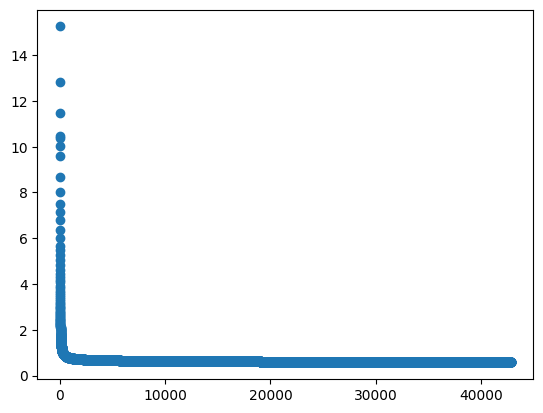

In [10]:
plt.scatter([i for i in range(len(mimicloss))],mimicloss)

In [ ]:
def _evaluate_acc_f1_threshold(data_loader, model, threshold):#evaluation with threshold, not used
    n_correct, n_total = 0, 0
    t_targets_all, t_outputs_all = None, None
    # switch model to evaluation mode
    model.eval()
    with torch.no_grad():
        for t_batch, t_sample_batched in enumerate(data_loader):
            t_inputs = t_sample_batched['features']
            t_targets = t_sample_batched['class_n']
            t_outputs = model(t_inputs)
            m=torch.nn.Softmax(dim=1)
            t_outputs=m(t_outputs)
            t_outputs_modified=t_outputs.clone()
            t_outputs_modified[t_outputs_modified[:, 1] >= threshold, 1] = 1
            t_outputs_modified[t_outputs_modified[:, 1] < threshold, 1] = 0
            n_correct += (t_outputs_modified[:, 1] == t_targets).sum().item()
            n_total += len(t_outputs)
            print("n_correct",n_correct)
            print(t_outputs_modified)
            if t_targets_all is None:
                t_targets_all = t_targets
                t_outputs_all = t_outputs_modified
            else:
                t_targets_all = torch.cat((t_targets_all, t_targets), dim=0)
                t_outputs_all = torch.cat((t_outputs_all, t_outputs_modified), dim=0)
#     print(t_targets_all)
    acc = n_correct / n_total
#     print('printing just output')
#     print(t_outputs_all[:,1])
    print(torch.argmax(t_outputs_all, -1).cpu())
    f1 = metrics.f1_score(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), labels=[0, 1], average='macro')
    report = classification_report(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), target_names=['class0','class1'], output_dict=True, digits = 4)
#     threshold=sorted(t_outputs.detach().numpy(),reverse=True,key=lambda x:x[1])[sum(targets)][1]
#     print(threshold)
    threshold=0.5
    return acc, f1, report,threshold